In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'features_clin' : ['CAP'],
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_2048_1024_512_256_128_0001_CCE_7_1_1_0_0_0_e_CAP_e_1_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3778099, 829)
(3778099, 8)
validation
(397815, 829)
(397815, 8)
test
(482242, 829)
(482242, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 829)]             0         


 dense (Dense)               (None, 2048)              1699840   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 4488072 (17.12 MB)


Trainable params: 4488072 (17.12 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/38 [..............................] - ETA: 6:55 - loss: 2.1843 - STD: 0.0725 - MAE: 0.2157

 2/38 [>.............................] - ETA: 13s - loss: 2.1272 - STD: 0.0551 - MAE: 0.2163 

 3/38 [=>............................] - ETA: 14s - loss: 2.1043 - STD: 0.0460 - MAE: 0.2166

 4/38 [==>...........................] - ETA: 13s - loss: 2.0969 - STD: 0.0440 - MAE: 0.2167

 5/38 [==>...........................] - ETA: 13s - loss: 2.0934 - STD: 0.0434 - MAE: 0.2167

 6/38 [===>..........................] - ETA: 12s - loss: 2.0909 - STD: 0.0431 - MAE: 0.2167

 7/38 [====>.........................] - ETA: 12s - loss: 2.0880 - STD: 0.0427 - MAE: 0.2167

 8/38 [=====>........................] - ETA: 12s - loss: 2.0851 - STD: 0.0421 - MAE: 0.2167

 9/38 [======>.......................] - ETA: 11s - loss: 2.0819 - STD: 0.0411 - MAE: 0.2167

10/38 [======>.......................] - ETA: 11s - loss: 2.0790 - STD: 0.0399 - MAE: 0.2167

11/38 [=======>......................] - ETA: 10s - loss: 2.0767 - STD: 0.0389 - MAE: 0.2168

12/38 [========>.....................] - ETA: 10s - loss: 2.0750 - STD: 0.0383 - MAE: 0.2168

13/38 [=========>....................] - ETA: 10s - loss: 2.0739 - STD: 0.0381 - MAE: 0.2168

14/38 [==========>...................] - ETA: 9s - loss: 2.0728 - STD: 0.0380 - MAE: 0.2168 

15/38 [==========>...................] - ETA: 9s - loss: 2.0719 - STD: 0.0380 - MAE: 0.2167

16/38 [===========>..................] - ETA: 8s - loss: 2.0709 - STD: 0.0379 - MAE: 0.2167

17/38 [============>.................] - ETA: 8s - loss: 2.0698 - STD: 0.0377 - MAE: 0.2167

18/38 [=============>................] - ETA: 8s - loss: 2.0687 - STD: 0.0373 - MAE: 0.2167

19/38 [==============>...............] - ETA: 7s - loss: 2.0676 - STD: 0.0370 - MAE: 0.2167

20/38 [==============>...............] - ETA: 14s - loss: 2.0668 - STD: 0.0367 - MAE: 0.2167

21/38 [===============>..............] - ETA: 12s - loss: 2.0659 - STD: 0.0365 - MAE: 0.2167

22/38 [================>.............] - ETA: 11s - loss: 2.0652 - STD: 0.0363 - MAE: 0.2167

23/38 [=================>............] - ETA: 10s - loss: 2.0644 - STD: 0.0362 - MAE: 0.2167

24/38 [=================>............] - ETA: 9s - loss: 2.0635 - STD: 0.0360 - MAE: 0.2167 

25/38 [==================>...........] - ETA: 9s - loss: 2.0627 - STD: 0.0359 - MAE: 0.2167

26/38 [===================>..........] - ETA: 8s - loss: 2.0617 - STD: 0.0357 - MAE: 0.2166

27/38 [====================>.........] - ETA: 7s - loss: 2.0605 - STD: 0.0355 - MAE: 0.2166

28/38 [=====================>........] - ETA: 6s - loss: 2.0593 - STD: 0.0354 - MAE: 0.2166

29/38 [=====================>........] - ETA: 5s - loss: 2.0579 - STD: 0.0354 - MAE: 0.2165

30/38 [======================>.......] - ETA: 5s - loss: 2.0563 - STD: 0.0354 - MAE: 0.2165

31/38 [=======================>......] - ETA: 4s - loss: 2.0544 - STD: 0.0354 - MAE: 0.2164

32/38 [========================>.....] - ETA: 3s - loss: 2.0523 - STD: 0.0355 - MAE: 0.2163

33/38 [=========================>....] - ETA: 3s - loss: 2.0500 - STD: 0.0358 - MAE: 0.2162

34/38 [=========================>....] - ETA: 2s - loss: 2.0475 - STD: 0.0361 - MAE: 0.2161

35/38 [==========================>...] - ETA: 1s - loss: 2.0447 - STD: 0.0366 - MAE: 0.2160

36/38 [===========================>..] - ETA: 1s - loss: 2.0416 - STD: 0.0371 - MAE: 0.2158

37/38 [============================>.] - ETA: 0s - loss: 2.0385 - STD: 0.0379 - MAE: 0.2156

38/38 [==============================] - ETA: 0s - loss: 2.0351 - STD: 0.0385 - MAE: 0.2154

38/38 [==============================] - 39s 748ms/step - loss: 2.0351 - STD: 0.0385 - MAE: 0.2154 - val_loss: 1.8935 - val_STD: 0.0701 - val_MAE: 0.2074


Epoch 2/10000


 1/38 [..............................] - ETA: 26s - loss: 1.8969 - STD: 0.0647 - MAE: 0.2080

 2/38 [>.............................] - ETA: 15s - loss: 1.8897 - STD: 0.0649 - MAE: 0.2078

 3/38 [=>............................] - ETA: 14s - loss: 1.8839 - STD: 0.0645 - MAE: 0.2076

 4/38 [==>...........................] - ETA: 13s - loss: 1.8785 - STD: 0.0660 - MAE: 0.2072

 5/38 [==>...........................] - ETA: 13s - loss: 1.8726 - STD: 0.0671 - MAE: 0.2069

 6/38 [===>..........................] - ETA: 13s - loss: 1.8667 - STD: 0.0690 - MAE: 0.2064

 7/38 [====>.........................] - ETA: 13s - loss: 1.8609 - STD: 0.0706 - MAE: 0.2060

 8/38 [=====>........................] - ETA: 13s - loss: 1.8551 - STD: 0.0717 - MAE: 0.2056

 9/38 [======>.......................] - ETA: 12s - loss: 1.8498 - STD: 0.0729 - MAE: 0.2053

10/38 [======>.......................] - ETA: 12s - loss: 1.8444 - STD: 0.0739 - MAE: 0.2050

11/38 [=======>......................] - ETA: 11s - loss: 1.8393 - STD: 0.0752 - MAE: 0.2046

12/38 [========>.....................] - ETA: 11s - loss: 1.8343 - STD: 0.0766 - MAE: 0.2042

13/38 [=========>....................] - ETA: 10s - loss: 1.8295 - STD: 0.0779 - MAE: 0.2038

14/38 [==========>...................] - ETA: 10s - loss: 1.8250 - STD: 0.0791 - MAE: 0.2035

15/38 [==========>...................] - ETA: 9s - loss: 1.8206 - STD: 0.0801 - MAE: 0.2032 

16/38 [===========>..................] - ETA: 9s - loss: 1.8162 - STD: 0.0810 - MAE: 0.2029

17/38 [============>.................] - ETA: 8s - loss: 1.8117 - STD: 0.0820 - MAE: 0.2026

18/38 [=============>................] - ETA: 8s - loss: 1.8075 - STD: 0.0830 - MAE: 0.2023

19/38 [==============>...............] - ETA: 7s - loss: 1.8034 - STD: 0.0840 - MAE: 0.2020

20/38 [==============>...............] - ETA: 7s - loss: 1.7993 - STD: 0.0847 - MAE: 0.2018

21/38 [===============>..............] - ETA: 7s - loss: 1.7950 - STD: 0.0854 - MAE: 0.2015

22/38 [================>.............] - ETA: 6s - loss: 1.7907 - STD: 0.0862 - MAE: 0.2012

23/38 [=================>............] - ETA: 6s - loss: 1.7866 - STD: 0.0870 - MAE: 0.2010

24/38 [=================>............] - ETA: 5s - loss: 1.7828 - STD: 0.0878 - MAE: 0.2007

25/38 [==================>...........] - ETA: 5s - loss: 1.7804 - STD: 0.0882 - MAE: 0.2006

26/38 [===================>..........] - ETA: 4s - loss: 1.7764 - STD: 0.0888 - MAE: 0.2004

27/38 [====================>.........] - ETA: 4s - loss: 1.7726 - STD: 0.0896 - MAE: 0.2002

28/38 [=====================>........] - ETA: 4s - loss: 1.7696 - STD: 0.0901 - MAE: 0.2000

29/38 [=====================>........] - ETA: 3s - loss: 1.7660 - STD: 0.0907 - MAE: 0.1998

30/38 [======================>.......] - ETA: 3s - loss: 1.7625 - STD: 0.0913 - MAE: 0.1996

31/38 [=======================>......] - ETA: 2s - loss: 1.7595 - STD: 0.0916 - MAE: 0.1995

32/38 [========================>.....] - ETA: 2s - loss: 1.7558 - STD: 0.0922 - MAE: 0.1993

33/38 [=========================>....] - ETA: 2s - loss: 1.7526 - STD: 0.0928 - MAE: 0.1990

34/38 [=========================>....] - ETA: 1s - loss: 1.7494 - STD: 0.0932 - MAE: 0.1989

35/38 [==========================>...] - ETA: 1s - loss: 1.7458 - STD: 0.0936 - MAE: 0.1987

36/38 [===========================>..] - ETA: 0s - loss: 1.7426 - STD: 0.0942 - MAE: 0.1985

37/38 [============================>.] - ETA: 0s - loss: 1.7391 - STD: 0.0946 - MAE: 0.1983

38/38 [==============================] - ETA: 0s - loss: 1.7357 - STD: 0.0950 - MAE: 0.1982

38/38 [==============================] - 18s 470ms/step - loss: 1.7357 - STD: 0.0950 - MAE: 0.1982 - val_loss: 1.6999 - val_STD: 0.1202 - val_MAE: 0.1920


Epoch 3/10000


 1/38 [..............................] - ETA: 30s - loss: 1.6040 - STD: 0.1141 - MAE: 0.1905

 2/38 [>.............................] - ETA: 15s - loss: 1.5956 - STD: 0.1131 - MAE: 0.1903

 3/38 [=>............................] - ETA: 15s - loss: 1.5911 - STD: 0.1130 - MAE: 0.1902

 4/38 [==>...........................] - ETA: 14s - loss: 1.5850 - STD: 0.1138 - MAE: 0.1898

 5/38 [==>...........................] - ETA: 14s - loss: 1.5787 - STD: 0.1141 - MAE: 0.1894

 6/38 [===>..........................] - ETA: 13s - loss: 1.5729 - STD: 0.1145 - MAE: 0.1891

 7/38 [====>.........................] - ETA: 13s - loss: 1.5666 - STD: 0.1152 - MAE: 0.1887

 8/38 [=====>........................] - ETA: 12s - loss: 1.5604 - STD: 0.1157 - MAE: 0.1883

 9/38 [======>.......................] - ETA: 12s - loss: 1.5538 - STD: 0.1163 - MAE: 0.1879

10/38 [======>.......................] - ETA: 11s - loss: 1.5474 - STD: 0.1170 - MAE: 0.1875

11/38 [=======>......................] - ETA: 11s - loss: 1.5415 - STD: 0.1177 - MAE: 0.1871

12/38 [========>.....................] - ETA: 10s - loss: 1.5361 - STD: 0.1185 - MAE: 0.1867

13/38 [=========>....................] - ETA: 10s - loss: 1.5306 - STD: 0.1192 - MAE: 0.1863

14/38 [==========>...................] - ETA: 10s - loss: 1.5248 - STD: 0.1200 - MAE: 0.1859

15/38 [==========>...................] - ETA: 9s - loss: 1.5190 - STD: 0.1207 - MAE: 0.1855 

16/38 [===========>..................] - ETA: 9s - loss: 1.5136 - STD: 0.1215 - MAE: 0.1850

17/38 [============>.................] - ETA: 9s - loss: 1.5086 - STD: 0.1222 - MAE: 0.1847

18/38 [=============>................] - ETA: 8s - loss: 1.5037 - STD: 0.1229 - MAE: 0.1843

19/38 [==============>...............] - ETA: 8s - loss: 1.4988 - STD: 0.1237 - MAE: 0.1839

20/38 [==============>...............] - ETA: 7s - loss: 1.4941 - STD: 0.1245 - MAE: 0.1835

21/38 [===============>..............] - ETA: 7s - loss: 1.4894 - STD: 0.1252 - MAE: 0.1831

22/38 [================>.............] - ETA: 6s - loss: 1.4851 - STD: 0.1260 - MAE: 0.1827

23/38 [=================>............] - ETA: 6s - loss: 1.4808 - STD: 0.1267 - MAE: 0.1823

24/38 [=================>............] - ETA: 6s - loss: 1.4773 - STD: 0.1274 - MAE: 0.1820

25/38 [==================>...........] - ETA: 5s - loss: 1.4740 - STD: 0.1281 - MAE: 0.1817

26/38 [===================>..........] - ETA: 5s - loss: 1.4713 - STD: 0.1288 - MAE: 0.1813

27/38 [====================>.........] - ETA: 4s - loss: 1.4677 - STD: 0.1294 - MAE: 0.1810

28/38 [=====================>........] - ETA: 4s - loss: 1.4642 - STD: 0.1301 - MAE: 0.1807

29/38 [=====================>........] - ETA: 3s - loss: 1.4608 - STD: 0.1307 - MAE: 0.1803

30/38 [======================>.......] - ETA: 3s - loss: 1.4574 - STD: 0.1313 - MAE: 0.1800

31/38 [=======================>......] - ETA: 2s - loss: 1.4543 - STD: 0.1319 - MAE: 0.1797

32/38 [========================>.....] - ETA: 2s - loss: 1.4512 - STD: 0.1324 - MAE: 0.1794

33/38 [=========================>....] - ETA: 2s - loss: 1.4480 - STD: 0.1330 - MAE: 0.1791

34/38 [=========================>....] - ETA: 1s - loss: 1.4451 - STD: 0.1335 - MAE: 0.1788

35/38 [==========================>...] - ETA: 1s - loss: 1.4422 - STD: 0.1340 - MAE: 0.1786

36/38 [===========================>..] - ETA: 0s - loss: 1.4393 - STD: 0.1346 - MAE: 0.1783

37/38 [============================>.] - ETA: 0s - loss: 1.4366 - STD: 0.1351 - MAE: 0.1780

38/38 [==============================] - ETA: 0s - loss: 1.4339 - STD: 0.1356 - MAE: 0.1778

38/38 [==============================] - 18s 477ms/step - loss: 1.4339 - STD: 0.1356 - MAE: 0.1778 - val_loss: 1.4447 - val_STD: 0.1599 - val_MAE: 0.1709


Epoch 4/10000


 1/38 [..............................] - ETA: 27s - loss: 1.3342 - STD: 0.1546 - MAE: 0.1676

 2/38 [>.............................] - ETA: 23s - loss: 1.3328 - STD: 0.1553 - MAE: 0.1674

 3/38 [=>............................] - ETA: 18s - loss: 1.3309 - STD: 0.1554 - MAE: 0.1673

 4/38 [==>...........................] - ETA: 16s - loss: 1.3290 - STD: 0.1559 - MAE: 0.1670

 5/38 [==>...........................] - ETA: 16s - loss: 1.3293 - STD: 0.1563 - MAE: 0.1669

 6/38 [===>..........................] - ETA: 15s - loss: 1.3321 - STD: 0.1565 - MAE: 0.1669

 7/38 [====>.........................] - ETA: 14s - loss: 1.3325 - STD: 0.1568 - MAE: 0.1668

 8/38 [=====>........................] - ETA: 14s - loss: 1.3308 - STD: 0.1571 - MAE: 0.1667

 9/38 [======>.......................] - ETA: 14s - loss: 1.3293 - STD: 0.1573 - MAE: 0.1665

10/38 [======>.......................] - ETA: 13s - loss: 1.3281 - STD: 0.1576 - MAE: 0.1663

11/38 [=======>......................] - ETA: 12s - loss: 1.3276 - STD: 0.1579 - MAE: 0.1662

12/38 [========>.....................] - ETA: 12s - loss: 1.3274 - STD: 0.1581 - MAE: 0.1661

13/38 [=========>....................] - ETA: 11s - loss: 1.3263 - STD: 0.1584 - MAE: 0.1660

14/38 [==========>...................] - ETA: 11s - loss: 1.3248 - STD: 0.1586 - MAE: 0.1659

15/38 [==========>...................] - ETA: 10s - loss: 1.3241 - STD: 0.1588 - MAE: 0.1658

16/38 [===========>..................] - ETA: 10s - loss: 1.3235 - STD: 0.1590 - MAE: 0.1657

17/38 [============>.................] - ETA: 9s - loss: 1.3226 - STD: 0.1592 - MAE: 0.1655 

18/38 [=============>................] - ETA: 9s - loss: 1.3213 - STD: 0.1594 - MAE: 0.1654

19/38 [==============>...............] - ETA: 8s - loss: 1.3200 - STD: 0.1597 - MAE: 0.1653

20/38 [==============>...............] - ETA: 8s - loss: 1.3192 - STD: 0.1598 - MAE: 0.1652

21/38 [===============>..............] - ETA: 7s - loss: 1.3185 - STD: 0.1600 - MAE: 0.1651

22/38 [================>.............] - ETA: 7s - loss: 1.3175 - STD: 0.1602 - MAE: 0.1650

23/38 [=================>............] - ETA: 6s - loss: 1.3165 - STD: 0.1603 - MAE: 0.1649

24/38 [=================>............] - ETA: 6s - loss: 1.3156 - STD: 0.1605 - MAE: 0.1648

25/38 [==================>...........] - ETA: 5s - loss: 1.3148 - STD: 0.1607 - MAE: 0.1647

26/38 [===================>..........] - ETA: 5s - loss: 1.3141 - STD: 0.1608 - MAE: 0.1646

27/38 [====================>.........] - ETA: 4s - loss: 1.3132 - STD: 0.1609 - MAE: 0.1646

28/38 [=====================>........] - ETA: 4s - loss: 1.3125 - STD: 0.1610 - MAE: 0.1645

29/38 [=====================>........] - ETA: 4s - loss: 1.3116 - STD: 0.1612 - MAE: 0.1644

30/38 [======================>.......] - ETA: 3s - loss: 1.3109 - STD: 0.1613 - MAE: 0.1643

31/38 [=======================>......] - ETA: 3s - loss: 1.3101 - STD: 0.1614 - MAE: 0.1642

32/38 [========================>.....] - ETA: 2s - loss: 1.3094 - STD: 0.1616 - MAE: 0.1642

33/38 [=========================>....] - ETA: 2s - loss: 1.3089 - STD: 0.1617 - MAE: 0.1641

34/38 [=========================>....] - ETA: 1s - loss: 1.3081 - STD: 0.1618 - MAE: 0.1640

35/38 [==========================>...] - ETA: 1s - loss: 1.3073 - STD: 0.1619 - MAE: 0.1639

36/38 [===========================>..] - ETA: 0s - loss: 1.3065 - STD: 0.1621 - MAE: 0.1639

37/38 [============================>.] - ETA: 0s - loss: 1.3057 - STD: 0.1622 - MAE: 0.1638

38/38 [==============================] - ETA: 0s - loss: 1.3049 - STD: 0.1623 - MAE: 0.1637

38/38 [==============================] - 19s 501ms/step - loss: 1.3049 - STD: 0.1623 - MAE: 0.1637 - val_loss: 1.4029 - val_STD: 0.1720 - val_MAE: 0.1648


Epoch 5/10000


 1/38 [..............................] - ETA: 36s - loss: 1.2714 - STD: 0.1671 - MAE: 0.1605

 2/38 [>.............................] - ETA: 14s - loss: 1.2718 - STD: 0.1666 - MAE: 0.1606

 3/38 [=>............................] - ETA: 17s - loss: 1.2723 - STD: 0.1666 - MAE: 0.1607

 4/38 [==>...........................] - ETA: 15s - loss: 1.2734 - STD: 0.1671 - MAE: 0.1606

 5/38 [==>...........................] - ETA: 15s - loss: 1.2738 - STD: 0.1670 - MAE: 0.1606

 6/38 [===>..........................] - ETA: 15s - loss: 1.2752 - STD: 0.1674 - MAE: 0.1606

 7/38 [====>.........................] - ETA: 14s - loss: 1.2773 - STD: 0.1673 - MAE: 0.1607

 8/38 [=====>........................] - ETA: 13s - loss: 1.2821 - STD: 0.1674 - MAE: 0.1609

 9/38 [======>.......................] - ETA: 13s - loss: 1.2917 - STD: 0.1677 - MAE: 0.1612

10/38 [======>.......................] - ETA: 12s - loss: 1.2948 - STD: 0.1676 - MAE: 0.1614

11/38 [=======>......................] - ETA: 11s - loss: 1.2931 - STD: 0.1678 - MAE: 0.1612

12/38 [========>.....................] - ETA: 11s - loss: 1.2948 - STD: 0.1679 - MAE: 0.1613

13/38 [=========>....................] - ETA: 10s - loss: 1.2944 - STD: 0.1680 - MAE: 0.1612

14/38 [==========>...................] - ETA: 10s - loss: 1.2925 - STD: 0.1681 - MAE: 0.1611

15/38 [==========>...................] - ETA: 9s - loss: 1.2934 - STD: 0.1681 - MAE: 0.1611 

16/38 [===========>..................] - ETA: 9s - loss: 1.2915 - STD: 0.1681 - MAE: 0.1610

17/38 [============>.................] - ETA: 9s - loss: 1.2913 - STD: 0.1681 - MAE: 0.1610

18/38 [=============>................] - ETA: 8s - loss: 1.2904 - STD: 0.1681 - MAE: 0.1610

19/38 [==============>...............] - ETA: 8s - loss: 1.2889 - STD: 0.1681 - MAE: 0.1609

20/38 [==============>...............] - ETA: 7s - loss: 1.2885 - STD: 0.1682 - MAE: 0.1609

21/38 [===============>..............] - ETA: 7s - loss: 1.2866 - STD: 0.1682 - MAE: 0.1608

22/38 [================>.............] - ETA: 6s - loss: 1.2859 - STD: 0.1682 - MAE: 0.1607

23/38 [=================>............] - ETA: 6s - loss: 1.2847 - STD: 0.1684 - MAE: 0.1606

24/38 [=================>............] - ETA: 5s - loss: 1.2835 - STD: 0.1685 - MAE: 0.1605

25/38 [==================>...........] - ETA: 5s - loss: 1.2828 - STD: 0.1685 - MAE: 0.1605

26/38 [===================>..........] - ETA: 5s - loss: 1.2815 - STD: 0.1686 - MAE: 0.1604

27/38 [====================>.........] - ETA: 4s - loss: 1.2806 - STD: 0.1686 - MAE: 0.1603

28/38 [=====================>........] - ETA: 4s - loss: 1.2795 - STD: 0.1687 - MAE: 0.1603

29/38 [=====================>........] - ETA: 3s - loss: 1.2784 - STD: 0.1688 - MAE: 0.1602

30/38 [======================>.......] - ETA: 3s - loss: 1.2776 - STD: 0.1688 - MAE: 0.1601

31/38 [=======================>......] - ETA: 2s - loss: 1.2764 - STD: 0.1689 - MAE: 0.1600

32/38 [========================>.....] - ETA: 2s - loss: 1.2756 - STD: 0.1690 - MAE: 0.1600

33/38 [=========================>....] - ETA: 2s - loss: 1.2745 - STD: 0.1691 - MAE: 0.1599

34/38 [=========================>....] - ETA: 1s - loss: 1.2735 - STD: 0.1692 - MAE: 0.1598

35/38 [==========================>...] - ETA: 1s - loss: 1.2726 - STD: 0.1693 - MAE: 0.1597

36/38 [===========================>..] - ETA: 0s - loss: 1.2716 - STD: 0.1693 - MAE: 0.1597

37/38 [============================>.] - ETA: 0s - loss: 1.2709 - STD: 0.1694 - MAE: 0.1596

38/38 [==============================] - ETA: 0s - loss: 1.2700 - STD: 0.1695 - MAE: 0.1595

38/38 [==============================] - 18s 468ms/step - loss: 1.2700 - STD: 0.1695 - MAE: 0.1595 - val_loss: 1.3910 - val_STD: 0.1782 - val_MAE: 0.1618


Epoch 6/10000


 1/38 [..............................] - ETA: 29s - loss: 1.2358 - STD: 0.1732 - MAE: 0.1567

 2/38 [>.............................] - ETA: 21s - loss: 1.2359 - STD: 0.1735 - MAE: 0.1566

 3/38 [=>............................] - ETA: 17s - loss: 1.2340 - STD: 0.1733 - MAE: 0.1565

 4/38 [==>...........................] - ETA: 18s - loss: 1.2335 - STD: 0.1734 - MAE: 0.1565

 5/38 [==>...........................] - ETA: 16s - loss: 1.2335 - STD: 0.1736 - MAE: 0.1564

 6/38 [===>..........................] - ETA: 15s - loss: 1.2332 - STD: 0.1738 - MAE: 0.1564

 7/38 [====>.........................] - ETA: 14s - loss: 1.2326 - STD: 0.1739 - MAE: 0.1563

 8/38 [=====>........................] - ETA: 14s - loss: 1.2318 - STD: 0.1740 - MAE: 0.1562

 9/38 [======>.......................] - ETA: 13s - loss: 1.2314 - STD: 0.1741 - MAE: 0.1561

10/38 [======>.......................] - ETA: 13s - loss: 1.2307 - STD: 0.1742 - MAE: 0.1561

11/38 [=======>......................] - ETA: 12s - loss: 1.2302 - STD: 0.1744 - MAE: 0.1560

12/38 [========>.....................] - ETA: 11s - loss: 1.2301 - STD: 0.1744 - MAE: 0.1560

13/38 [=========>....................] - ETA: 11s - loss: 1.2297 - STD: 0.1745 - MAE: 0.1559

14/38 [==========>...................] - ETA: 10s - loss: 1.2295 - STD: 0.1745 - MAE: 0.1559

15/38 [==========>...................] - ETA: 10s - loss: 1.2298 - STD: 0.1747 - MAE: 0.1559

16/38 [===========>..................] - ETA: 10s - loss: 1.2299 - STD: 0.1747 - MAE: 0.1559

17/38 [============>.................] - ETA: 9s - loss: 1.2299 - STD: 0.1748 - MAE: 0.1558 

18/38 [=============>................] - ETA: 9s - loss: 1.2298 - STD: 0.1748 - MAE: 0.1558

19/38 [==============>...............] - ETA: 8s - loss: 1.2291 - STD: 0.1749 - MAE: 0.1558

20/38 [==============>...............] - ETA: 8s - loss: 1.2287 - STD: 0.1750 - MAE: 0.1557

21/38 [===============>..............] - ETA: 7s - loss: 1.2285 - STD: 0.1750 - MAE: 0.1557

22/38 [================>.............] - ETA: 7s - loss: 1.2282 - STD: 0.1752 - MAE: 0.1556

23/38 [=================>............] - ETA: 6s - loss: 1.2280 - STD: 0.1752 - MAE: 0.1556

24/38 [=================>............] - ETA: 6s - loss: 1.2278 - STD: 0.1753 - MAE: 0.1556

25/38 [==================>...........] - ETA: 5s - loss: 1.2273 - STD: 0.1754 - MAE: 0.1555

26/38 [===================>..........] - ETA: 5s - loss: 1.2265 - STD: 0.1754 - MAE: 0.1554

27/38 [====================>.........] - ETA: 4s - loss: 1.2262 - STD: 0.1756 - MAE: 0.1554

28/38 [=====================>........] - ETA: 4s - loss: 1.2256 - STD: 0.1756 - MAE: 0.1553

29/38 [=====================>........] - ETA: 4s - loss: 1.2254 - STD: 0.1757 - MAE: 0.1553

30/38 [======================>.......] - ETA: 3s - loss: 1.2251 - STD: 0.1758 - MAE: 0.1553

31/38 [=======================>......] - ETA: 3s - loss: 1.2249 - STD: 0.1759 - MAE: 0.1552

32/38 [========================>.....] - ETA: 2s - loss: 1.2247 - STD: 0.1760 - MAE: 0.1552

33/38 [=========================>....] - ETA: 2s - loss: 1.2243 - STD: 0.1761 - MAE: 0.1551

34/38 [=========================>....] - ETA: 1s - loss: 1.2239 - STD: 0.1761 - MAE: 0.1551

35/38 [==========================>...] - ETA: 1s - loss: 1.2233 - STD: 0.1762 - MAE: 0.1550

36/38 [===========================>..] - ETA: 0s - loss: 1.2229 - STD: 0.1763 - MAE: 0.1550

37/38 [============================>.] - ETA: 0s - loss: 1.2223 - STD: 0.1763 - MAE: 0.1549

38/38 [==============================] - ETA: 0s - loss: 1.2216 - STD: 0.1764 - MAE: 0.1549

38/38 [==============================] - 19s 500ms/step - loss: 1.2216 - STD: 0.1764 - MAE: 0.1549 - val_loss: 1.3631 - val_STD: 0.1837 - val_MAE: 0.1584


Epoch 7/10000


 1/38 [..............................] - ETA: 23s - loss: 1.2061 - STD: 0.1791 - MAE: 0.1532

 2/38 [>.............................] - ETA: 14s - loss: 1.2048 - STD: 0.1799 - MAE: 0.1528

 3/38 [=>............................] - ETA: 15s - loss: 1.2055 - STD: 0.1800 - MAE: 0.1529

 4/38 [==>...........................] - ETA: 14s - loss: 1.2048 - STD: 0.1802 - MAE: 0.1528

 5/38 [==>...........................] - ETA: 15s - loss: 1.2044 - STD: 0.1797 - MAE: 0.1529

 6/38 [===>..........................] - ETA: 14s - loss: 1.2063 - STD: 0.1800 - MAE: 0.1529

 7/38 [====>.........................] - ETA: 14s - loss: 1.2099 - STD: 0.1795 - MAE: 0.1532

 8/38 [=====>........................] - ETA: 13s - loss: 1.2155 - STD: 0.1802 - MAE: 0.1533

 9/38 [======>.......................] - ETA: 13s - loss: 1.2204 - STD: 0.1796 - MAE: 0.1538

10/38 [======>.......................] - ETA: 12s - loss: 1.2199 - STD: 0.1797 - MAE: 0.1537

11/38 [=======>......................] - ETA: 12s - loss: 1.2189 - STD: 0.1796 - MAE: 0.1537

12/38 [========>.....................] - ETA: 11s - loss: 1.2210 - STD: 0.1792 - MAE: 0.1539

13/38 [=========>....................] - ETA: 11s - loss: 1.2205 - STD: 0.1795 - MAE: 0.1538

14/38 [==========>...................] - ETA: 10s - loss: 1.2191 - STD: 0.1794 - MAE: 0.1538

15/38 [==========>...................] - ETA: 10s - loss: 1.2186 - STD: 0.1792 - MAE: 0.1538

16/38 [===========>..................] - ETA: 9s - loss: 1.2185 - STD: 0.1795 - MAE: 0.1537 

17/38 [============>.................] - ETA: 9s - loss: 1.2170 - STD: 0.1796 - MAE: 0.1536

18/38 [=============>................] - ETA: 9s - loss: 1.2160 - STD: 0.1796 - MAE: 0.1536

19/38 [==============>...............] - ETA: 8s - loss: 1.2154 - STD: 0.1797 - MAE: 0.1535

20/38 [==============>...............] - ETA: 8s - loss: 1.2144 - STD: 0.1797 - MAE: 0.1535

21/38 [===============>..............] - ETA: 7s - loss: 1.2136 - STD: 0.1797 - MAE: 0.1534

22/38 [================>.............] - ETA: 7s - loss: 1.2130 - STD: 0.1799 - MAE: 0.1533

23/38 [=================>............] - ETA: 7s - loss: 1.2121 - STD: 0.1799 - MAE: 0.1533

24/38 [=================>............] - ETA: 6s - loss: 1.2111 - STD: 0.1800 - MAE: 0.1532

25/38 [==================>...........] - ETA: 6s - loss: 1.2104 - STD: 0.1801 - MAE: 0.1531

26/38 [===================>..........] - ETA: 5s - loss: 1.2097 - STD: 0.1802 - MAE: 0.1531

27/38 [====================>.........] - ETA: 5s - loss: 1.2088 - STD: 0.1803 - MAE: 0.1530

28/38 [=====================>........] - ETA: 4s - loss: 1.2083 - STD: 0.1804 - MAE: 0.1529

29/38 [=====================>........] - ETA: 4s - loss: 1.2083 - STD: 0.1803 - MAE: 0.1529

30/38 [======================>.......] - ETA: 3s - loss: 1.2083 - STD: 0.1804 - MAE: 0.1529

31/38 [=======================>......] - ETA: 3s - loss: 1.2088 - STD: 0.1804 - MAE: 0.1529

32/38 [========================>.....] - ETA: 2s - loss: 1.2096 - STD: 0.1805 - MAE: 0.1530

33/38 [=========================>....] - ETA: 2s - loss: 1.2097 - STD: 0.1805 - MAE: 0.1530

34/38 [=========================>....] - ETA: 1s - loss: 1.2091 - STD: 0.1805 - MAE: 0.1529

35/38 [==========================>...] - ETA: 1s - loss: 1.2085 - STD: 0.1806 - MAE: 0.1529

36/38 [===========================>..] - ETA: 0s - loss: 1.2082 - STD: 0.1807 - MAE: 0.1528

37/38 [============================>.] - ETA: 0s - loss: 1.2081 - STD: 0.1807 - MAE: 0.1528

38/38 [==============================] - ETA: 0s - loss: 1.2076 - STD: 0.1807 - MAE: 0.1528

38/38 [==============================] - 21s 543ms/step - loss: 1.2076 - STD: 0.1807 - MAE: 0.1528 - val_loss: 1.3689 - val_STD: 0.1874 - val_MAE: 0.1572


Epoch 8/10000


 1/38 [..............................] - ETA: 37s - loss: 1.1859 - STD: 0.1828 - MAE: 0.1510

 2/38 [>.............................] - ETA: 19s - loss: 1.1878 - STD: 0.1823 - MAE: 0.1512

 3/38 [=>............................] - ETA: 17s - loss: 1.1905 - STD: 0.1819 - MAE: 0.1515

 4/38 [==>...........................] - ETA: 15s - loss: 1.1909 - STD: 0.1822 - MAE: 0.1514

 5/38 [==>...........................] - ETA: 15s - loss: 1.1910 - STD: 0.1819 - MAE: 0.1515

 6/38 [===>..........................] - ETA: 14s - loss: 1.1890 - STD: 0.1822 - MAE: 0.1513

 7/38 [====>.........................] - ETA: 14s - loss: 1.1885 - STD: 0.1824 - MAE: 0.1512

 8/38 [=====>........................] - ETA: 14s - loss: 1.1881 - STD: 0.1824 - MAE: 0.1512

 9/38 [======>.......................] - ETA: 14s - loss: 1.1872 - STD: 0.1826 - MAE: 0.1511

10/38 [======>.......................] - ETA: 13s - loss: 1.1865 - STD: 0.1826 - MAE: 0.1511

11/38 [=======>......................] - ETA: 12s - loss: 1.1860 - STD: 0.1826 - MAE: 0.1510

12/38 [========>.....................] - ETA: 12s - loss: 1.1852 - STD: 0.1827 - MAE: 0.1510

13/38 [=========>....................] - ETA: 11s - loss: 1.1849 - STD: 0.1827 - MAE: 0.1510

14/38 [==========>...................] - ETA: 11s - loss: 1.1842 - STD: 0.1828 - MAE: 0.1509

15/38 [==========>...................] - ETA: 10s - loss: 1.1837 - STD: 0.1829 - MAE: 0.1508

16/38 [===========>..................] - ETA: 10s - loss: 1.1833 - STD: 0.1829 - MAE: 0.1508

17/38 [============>.................] - ETA: 9s - loss: 1.1827 - STD: 0.1830 - MAE: 0.1507 

18/38 [=============>................] - ETA: 9s - loss: 1.1822 - STD: 0.1830 - MAE: 0.1507

19/38 [==============>...............] - ETA: 8s - loss: 1.1816 - STD: 0.1830 - MAE: 0.1507

20/38 [==============>...............] - ETA: 8s - loss: 1.1810 - STD: 0.1831 - MAE: 0.1506

21/38 [===============>..............] - ETA: 7s - loss: 1.1806 - STD: 0.1831 - MAE: 0.1506

22/38 [================>.............] - ETA: 7s - loss: 1.1806 - STD: 0.1832 - MAE: 0.1505

23/38 [=================>............] - ETA: 7s - loss: 1.1804 - STD: 0.1833 - MAE: 0.1505

24/38 [=================>............] - ETA: 6s - loss: 1.1800 - STD: 0.1833 - MAE: 0.1505

25/38 [==================>...........] - ETA: 6s - loss: 1.1797 - STD: 0.1834 - MAE: 0.1504

26/38 [===================>..........] - ETA: 5s - loss: 1.1791 - STD: 0.1834 - MAE: 0.1504

27/38 [====================>.........] - ETA: 5s - loss: 1.1787 - STD: 0.1835 - MAE: 0.1504

28/38 [=====================>........] - ETA: 4s - loss: 1.1783 - STD: 0.1835 - MAE: 0.1503

29/38 [=====================>........] - ETA: 4s - loss: 1.1783 - STD: 0.1836 - MAE: 0.1503

30/38 [======================>.......] - ETA: 3s - loss: 1.1785 - STD: 0.1836 - MAE: 0.1503

31/38 [=======================>......] - ETA: 3s - loss: 1.1788 - STD: 0.1837 - MAE: 0.1503

32/38 [========================>.....] - ETA: 2s - loss: 1.1792 - STD: 0.1837 - MAE: 0.1503

33/38 [=========================>....] - ETA: 2s - loss: 1.1797 - STD: 0.1837 - MAE: 0.1503

34/38 [=========================>....] - ETA: 1s - loss: 1.1807 - STD: 0.1837 - MAE: 0.1504

35/38 [==========================>...] - ETA: 1s - loss: 1.1823 - STD: 0.1837 - MAE: 0.1505

36/38 [===========================>..] - ETA: 0s - loss: 1.1838 - STD: 0.1838 - MAE: 0.1505

37/38 [============================>.] - ETA: 0s - loss: 1.1843 - STD: 0.1838 - MAE: 0.1505

38/38 [==============================] - ETA: 0s - loss: 1.1841 - STD: 0.1839 - MAE: 0.1505

38/38 [==============================] - 20s 514ms/step - loss: 1.1841 - STD: 0.1839 - MAE: 0.1505 - val_loss: 1.4221 - val_STD: 0.1910 - val_MAE: 0.1575


Epoch 9/10000


 1/38 [..............................] - ETA: 33s - loss: 1.1978 - STD: 0.1855 - MAE: 0.1505

 2/38 [>.............................] - ETA: 20s - loss: 1.2026 - STD: 0.1853 - MAE: 0.1508

 3/38 [=>............................] - ETA: 19s - loss: 1.1935 - STD: 0.1848 - MAE: 0.1506

 4/38 [==>...........................] - ETA: 18s - loss: 1.1860 - STD: 0.1841 - MAE: 0.1505

 5/38 [==>...........................] - ETA: 16s - loss: 1.1873 - STD: 0.1843 - MAE: 0.1504

 6/38 [===>..........................] - ETA: 15s - loss: 1.1863 - STD: 0.1844 - MAE: 0.1504

 7/38 [====>.........................] - ETA: 15s - loss: 1.1832 - STD: 0.1844 - MAE: 0.1502

 8/38 [=====>........................] - ETA: 14s - loss: 1.1840 - STD: 0.1846 - MAE: 0.1502

 9/38 [======>.......................] - ETA: 14s - loss: 1.1834 - STD: 0.1847 - MAE: 0.1501

10/38 [======>.......................] - ETA: 14s - loss: 1.1812 - STD: 0.1850 - MAE: 0.1499

11/38 [=======>......................] - ETA: 13s - loss: 1.1805 - STD: 0.1850 - MAE: 0.1499

12/38 [========>.....................] - ETA: 12s - loss: 1.1802 - STD: 0.1850 - MAE: 0.1499

13/38 [=========>....................] - ETA: 12s - loss: 1.1783 - STD: 0.1848 - MAE: 0.1499

14/38 [==========>...................] - ETA: 11s - loss: 1.1779 - STD: 0.1848 - MAE: 0.1499

15/38 [==========>...................] - ETA: 10s - loss: 1.1773 - STD: 0.1849 - MAE: 0.1498

16/38 [===========>..................] - ETA: 10s - loss: 1.1757 - STD: 0.1849 - MAE: 0.1497

17/38 [============>.................] - ETA: 9s - loss: 1.1753 - STD: 0.1849 - MAE: 0.1497 

18/38 [=============>................] - ETA: 9s - loss: 1.1749 - STD: 0.1850 - MAE: 0.1497

19/38 [==============>...............] - ETA: 9s - loss: 1.1741 - STD: 0.1850 - MAE: 0.1496

20/38 [==============>...............] - ETA: 8s - loss: 1.1736 - STD: 0.1851 - MAE: 0.1495

21/38 [===============>..............] - ETA: 7s - loss: 1.1732 - STD: 0.1851 - MAE: 0.1495

22/38 [================>.............] - ETA: 7s - loss: 1.1723 - STD: 0.1852 - MAE: 0.1494

23/38 [=================>............] - ETA: 7s - loss: 1.1718 - STD: 0.1852 - MAE: 0.1494

24/38 [=================>............] - ETA: 6s - loss: 1.1714 - STD: 0.1853 - MAE: 0.1494

25/38 [==================>...........] - ETA: 6s - loss: 1.1712 - STD: 0.1852 - MAE: 0.1494

26/38 [===================>..........] - ETA: 5s - loss: 1.1711 - STD: 0.1853 - MAE: 0.1493

27/38 [====================>.........] - ETA: 5s - loss: 1.1720 - STD: 0.1853 - MAE: 0.1494

28/38 [=====================>........] - ETA: 4s - loss: 1.1740 - STD: 0.1855 - MAE: 0.1494

29/38 [=====================>........] - ETA: 4s - loss: 1.1762 - STD: 0.1854 - MAE: 0.1496

30/38 [======================>.......] - ETA: 3s - loss: 1.1766 - STD: 0.1854 - MAE: 0.1496

31/38 [=======================>......] - ETA: 3s - loss: 1.1762 - STD: 0.1853 - MAE: 0.1496

32/38 [========================>.....] - ETA: 2s - loss: 1.1765 - STD: 0.1852 - MAE: 0.1497

33/38 [=========================>....] - ETA: 2s - loss: 1.1771 - STD: 0.1853 - MAE: 0.1497

34/38 [=========================>....] - ETA: 1s - loss: 1.1768 - STD: 0.1853 - MAE: 0.1497

35/38 [==========================>...] - ETA: 1s - loss: 1.1762 - STD: 0.1852 - MAE: 0.1497

36/38 [===========================>..] - ETA: 0s - loss: 1.1766 - STD: 0.1854 - MAE: 0.1496

37/38 [============================>.] - ETA: 0s - loss: 1.1765 - STD: 0.1854 - MAE: 0.1496

38/38 [==============================] - ETA: 0s - loss: 1.1760 - STD: 0.1855 - MAE: 0.1496

38/38 [==============================] - 20s 505ms/step - loss: 1.1760 - STD: 0.1855 - MAE: 0.1496 - val_loss: 1.3959 - val_STD: 0.1930 - val_MAE: 0.1562


Epoch 10/10000


 1/38 [..............................] - ETA: 25s - loss: 1.1734 - STD: 0.1881 - MAE: 0.1486

 2/38 [>.............................] - ETA: 14s - loss: 1.1740 - STD: 0.1854 - MAE: 0.1495

 3/38 [=>............................] - ETA: 13s - loss: 1.1640 - STD: 0.1849 - MAE: 0.1492

 4/38 [==>...........................] - ETA: 14s - loss: 1.1650 - STD: 0.1854 - MAE: 0.1491

 5/38 [==>...........................] - ETA: 13s - loss: 1.1651 - STD: 0.1853 - MAE: 0.1491

 6/38 [===>..........................] - ETA: 13s - loss: 1.1620 - STD: 0.1858 - MAE: 0.1488

 7/38 [====>.........................] - ETA: 13s - loss: 1.1605 - STD: 0.1863 - MAE: 0.1485

 8/38 [=====>........................] - ETA: 12s - loss: 1.1604 - STD: 0.1865 - MAE: 0.1485

 9/38 [======>.......................] - ETA: 12s - loss: 1.1593 - STD: 0.1870 - MAE: 0.1482

10/38 [======>.......................] - ETA: 11s - loss: 1.1585 - STD: 0.1872 - MAE: 0.1481

11/38 [=======>......................] - ETA: 11s - loss: 1.1586 - STD: 0.1871 - MAE: 0.1481

12/38 [========>.....................] - ETA: 10s - loss: 1.1574 - STD: 0.1871 - MAE: 0.1481

13/38 [=========>....................] - ETA: 10s - loss: 1.1570 - STD: 0.1871 - MAE: 0.1481

14/38 [==========>...................] - ETA: 9s - loss: 1.1570 - STD: 0.1871 - MAE: 0.1481 

15/38 [==========>...................] - ETA: 9s - loss: 1.1566 - STD: 0.1871 - MAE: 0.1481

16/38 [===========>..................] - ETA: 9s - loss: 1.1557 - STD: 0.1871 - MAE: 0.1480

17/38 [============>.................] - ETA: 8s - loss: 1.1555 - STD: 0.1871 - MAE: 0.1480

18/38 [=============>................] - ETA: 8s - loss: 1.1549 - STD: 0.1872 - MAE: 0.1479

19/38 [==============>...............] - ETA: 7s - loss: 1.1544 - STD: 0.1873 - MAE: 0.1478

20/38 [==============>...............] - ETA: 7s - loss: 1.1541 - STD: 0.1873 - MAE: 0.1478

21/38 [===============>..............] - ETA: 6s - loss: 1.1536 - STD: 0.1873 - MAE: 0.1478

22/38 [================>.............] - ETA: 6s - loss: 1.1531 - STD: 0.1874 - MAE: 0.1478

23/38 [=================>............] - ETA: 6s - loss: 1.1526 - STD: 0.1874 - MAE: 0.1477

24/38 [=================>............] - ETA: 5s - loss: 1.1523 - STD: 0.1874 - MAE: 0.1477

25/38 [==================>...........] - ETA: 5s - loss: 1.1518 - STD: 0.1874 - MAE: 0.1477

26/38 [===================>..........] - ETA: 4s - loss: 1.1514 - STD: 0.1875 - MAE: 0.1476

27/38 [====================>.........] - ETA: 4s - loss: 1.1511 - STD: 0.1876 - MAE: 0.1476

28/38 [=====================>........] - ETA: 4s - loss: 1.1509 - STD: 0.1876 - MAE: 0.1476

29/38 [=====================>........] - ETA: 3s - loss: 1.1507 - STD: 0.1876 - MAE: 0.1475

30/38 [======================>.......] - ETA: 3s - loss: 1.1503 - STD: 0.1877 - MAE: 0.1475

31/38 [=======================>......] - ETA: 2s - loss: 1.1501 - STD: 0.1877 - MAE: 0.1475

32/38 [========================>.....] - ETA: 2s - loss: 1.1498 - STD: 0.1878 - MAE: 0.1475

33/38 [=========================>....] - ETA: 2s - loss: 1.1497 - STD: 0.1878 - MAE: 0.1474

34/38 [=========================>....] - ETA: 1s - loss: 1.1496 - STD: 0.1877 - MAE: 0.1474

35/38 [==========================>...] - ETA: 1s - loss: 1.1498 - STD: 0.1878 - MAE: 0.1474

36/38 [===========================>..] - ETA: 0s - loss: 1.1509 - STD: 0.1878 - MAE: 0.1475

37/38 [============================>.] - ETA: 0s - loss: 1.1531 - STD: 0.1880 - MAE: 0.1475

38/38 [==============================] - ETA: 0s - loss: 1.1550 - STD: 0.1879 - MAE: 0.1477

38/38 [==============================] - 17s 452ms/step - loss: 1.1550 - STD: 0.1879 - MAE: 0.1477 - val_loss: 1.3275 - val_STD: 0.1899 - val_MAE: 0.1541


Epoch 11/10000


 1/38 [..............................] - ETA: 27s - loss: 1.1791 - STD: 0.1874 - MAE: 0.1490

 2/38 [>.............................] - ETA: 15s - loss: 1.1742 - STD: 0.1869 - MAE: 0.1490

 3/38 [=>............................] - ETA: 14s - loss: 1.1765 - STD: 0.1859 - MAE: 0.1495

 4/38 [==>...........................] - ETA: 14s - loss: 1.1768 - STD: 0.1868 - MAE: 0.1493

 5/38 [==>...........................] - ETA: 13s - loss: 1.1723 - STD: 0.1871 - MAE: 0.1489

 6/38 [===>..........................] - ETA: 13s - loss: 1.1705 - STD: 0.1873 - MAE: 0.1487

 7/38 [====>.........................] - ETA: 13s - loss: 1.1698 - STD: 0.1880 - MAE: 0.1485

 8/38 [=====>........................] - ETA: 12s - loss: 1.1675 - STD: 0.1881 - MAE: 0.1483

 9/38 [======>.......................] - ETA: 12s - loss: 1.1662 - STD: 0.1881 - MAE: 0.1482

10/38 [======>.......................] - ETA: 12s - loss: 1.1653 - STD: 0.1882 - MAE: 0.1482

11/38 [=======>......................] - ETA: 11s - loss: 1.1635 - STD: 0.1880 - MAE: 0.1481

12/38 [========>.....................] - ETA: 11s - loss: 1.1616 - STD: 0.1878 - MAE: 0.1481

13/38 [=========>....................] - ETA: 10s - loss: 1.1607 - STD: 0.1879 - MAE: 0.1480

14/38 [==========>...................] - ETA: 10s - loss: 1.1595 - STD: 0.1879 - MAE: 0.1480

15/38 [==========>...................] - ETA: 9s - loss: 1.1580 - STD: 0.1879 - MAE: 0.1479 

16/38 [===========>..................] - ETA: 9s - loss: 1.1569 - STD: 0.1881 - MAE: 0.1477

17/38 [============>.................] - ETA: 8s - loss: 1.1560 - STD: 0.1882 - MAE: 0.1476

18/38 [=============>................] - ETA: 8s - loss: 1.1545 - STD: 0.1884 - MAE: 0.1475

19/38 [==============>...............] - ETA: 8s - loss: 1.1539 - STD: 0.1884 - MAE: 0.1475

20/38 [==============>...............] - ETA: 7s - loss: 1.1532 - STD: 0.1884 - MAE: 0.1474

21/38 [===============>..............] - ETA: 7s - loss: 1.1524 - STD: 0.1885 - MAE: 0.1474

22/38 [================>.............] - ETA: 6s - loss: 1.1515 - STD: 0.1885 - MAE: 0.1473

23/38 [=================>............] - ETA: 6s - loss: 1.1506 - STD: 0.1885 - MAE: 0.1473

24/38 [=================>............] - ETA: 5s - loss: 1.1499 - STD: 0.1885 - MAE: 0.1472

25/38 [==================>...........] - ETA: 5s - loss: 1.1490 - STD: 0.1886 - MAE: 0.1472

26/38 [===================>..........] - ETA: 5s - loss: 1.1482 - STD: 0.1886 - MAE: 0.1471

27/38 [====================>.........] - ETA: 4s - loss: 1.1475 - STD: 0.1887 - MAE: 0.1470

28/38 [=====================>........] - ETA: 4s - loss: 1.1471 - STD: 0.1888 - MAE: 0.1470

29/38 [=====================>........] - ETA: 3s - loss: 1.1466 - STD: 0.1888 - MAE: 0.1469

30/38 [======================>.......] - ETA: 3s - loss: 1.1459 - STD: 0.1889 - MAE: 0.1469

31/38 [=======================>......] - ETA: 2s - loss: 1.1453 - STD: 0.1889 - MAE: 0.1468

32/38 [========================>.....] - ETA: 2s - loss: 1.1448 - STD: 0.1890 - MAE: 0.1468

33/38 [=========================>....] - ETA: 2s - loss: 1.1443 - STD: 0.1890 - MAE: 0.1467

34/38 [=========================>....] - ETA: 1s - loss: 1.1436 - STD: 0.1890 - MAE: 0.1467

35/38 [==========================>...] - ETA: 1s - loss: 1.1432 - STD: 0.1891 - MAE: 0.1466

36/38 [===========================>..] - ETA: 0s - loss: 1.1429 - STD: 0.1891 - MAE: 0.1466

37/38 [============================>.] - ETA: 0s - loss: 1.1426 - STD: 0.1892 - MAE: 0.1466

38/38 [==============================] - ETA: 0s - loss: 1.1424 - STD: 0.1892 - MAE: 0.1465

38/38 [==============================] - 18s 469ms/step - loss: 1.1424 - STD: 0.1892 - MAE: 0.1465 - val_loss: 1.3096 - val_STD: 0.1958 - val_MAE: 0.1513


Epoch 12/10000


 1/38 [..............................] - ETA: 34s - loss: 1.1348 - STD: 0.1920 - MAE: 0.1452

 2/38 [>.............................] - ETA: 14s - loss: 1.1332 - STD: 0.1914 - MAE: 0.1453

 3/38 [=>............................] - ETA: 13s - loss: 1.1338 - STD: 0.1911 - MAE: 0.1454

 4/38 [==>...........................] - ETA: 13s - loss: 1.1332 - STD: 0.1913 - MAE: 0.1453

 5/38 [==>...........................] - ETA: 13s - loss: 1.1325 - STD: 0.1912 - MAE: 0.1453

 6/38 [===>..........................] - ETA: 13s - loss: 1.1315 - STD: 0.1912 - MAE: 0.1452

 7/38 [====>.........................] - ETA: 13s - loss: 1.1298 - STD: 0.1911 - MAE: 0.1452

 8/38 [=====>........................] - ETA: 12s - loss: 1.1286 - STD: 0.1912 - MAE: 0.1451

 9/38 [======>.......................] - ETA: 12s - loss: 1.1268 - STD: 0.1912 - MAE: 0.1450

10/38 [======>.......................] - ETA: 11s - loss: 1.1258 - STD: 0.1911 - MAE: 0.1449

11/38 [=======>......................] - ETA: 11s - loss: 1.1254 - STD: 0.1912 - MAE: 0.1449

12/38 [========>.....................] - ETA: 11s - loss: 1.1251 - STD: 0.1912 - MAE: 0.1449

13/38 [=========>....................] - ETA: 10s - loss: 1.1253 - STD: 0.1913 - MAE: 0.1449

14/38 [==========>...................] - ETA: 10s - loss: 1.1257 - STD: 0.1913 - MAE: 0.1449

15/38 [==========>...................] - ETA: 9s - loss: 1.1260 - STD: 0.1914 - MAE: 0.1449 

16/38 [===========>..................] - ETA: 9s - loss: 1.1265 - STD: 0.1914 - MAE: 0.1449

17/38 [============>.................] - ETA: 8s - loss: 1.1266 - STD: 0.1915 - MAE: 0.1449

18/38 [=============>................] - ETA: 8s - loss: 1.1262 - STD: 0.1914 - MAE: 0.1449

19/38 [==============>...............] - ETA: 8s - loss: 1.1258 - STD: 0.1914 - MAE: 0.1448

20/38 [==============>...............] - ETA: 7s - loss: 1.1255 - STD: 0.1914 - MAE: 0.1448

21/38 [===============>..............] - ETA: 7s - loss: 1.1252 - STD: 0.1914 - MAE: 0.1448

22/38 [================>.............] - ETA: 6s - loss: 1.1252 - STD: 0.1914 - MAE: 0.1448

23/38 [=================>............] - ETA: 6s - loss: 1.1265 - STD: 0.1915 - MAE: 0.1449

24/38 [=================>............] - ETA: 5s - loss: 1.1325 - STD: 0.1914 - MAE: 0.1452

25/38 [==================>...........] - ETA: 5s - loss: 1.1426 - STD: 0.1916 - MAE: 0.1456

26/38 [===================>..........] - ETA: 5s - loss: 1.1478 - STD: 0.1915 - MAE: 0.1459

27/38 [====================>.........] - ETA: 4s - loss: 1.1472 - STD: 0.1914 - MAE: 0.1459

28/38 [=====================>........] - ETA: 4s - loss: 1.1505 - STD: 0.1914 - MAE: 0.1461

29/38 [=====================>........] - ETA: 3s - loss: 1.1512 - STD: 0.1911 - MAE: 0.1462

30/38 [======================>.......] - ETA: 3s - loss: 1.1513 - STD: 0.1909 - MAE: 0.1463

31/38 [=======================>......] - ETA: 2s - loss: 1.1528 - STD: 0.1909 - MAE: 0.1464

32/38 [========================>.....] - ETA: 2s - loss: 1.1520 - STD: 0.1909 - MAE: 0.1463

33/38 [=========================>....] - ETA: 2s - loss: 1.1527 - STD: 0.1908 - MAE: 0.1464

34/38 [=========================>....] - ETA: 1s - loss: 1.1523 - STD: 0.1908 - MAE: 0.1464

35/38 [==========================>...] - ETA: 1s - loss: 1.1527 - STD: 0.1909 - MAE: 0.1464

36/38 [===========================>..] - ETA: 0s - loss: 1.1522 - STD: 0.1909 - MAE: 0.1463

37/38 [============================>.] - ETA: 0s - loss: 1.1522 - STD: 0.1908 - MAE: 0.1464

38/38 [==============================] - ETA: 0s - loss: 1.1518 - STD: 0.1908 - MAE: 0.1464

38/38 [==============================] - 18s 465ms/step - loss: 1.1518 - STD: 0.1908 - MAE: 0.1464 - val_loss: 1.2996 - val_STD: 0.1920 - val_MAE: 0.1523


Epoch 13/10000


 1/38 [..............................] - ETA: 30s - loss: 1.1346 - STD: 0.1882 - MAE: 0.1465

 2/38 [>.............................] - ETA: 13s - loss: 1.1364 - STD: 0.1895 - MAE: 0.1462

 3/38 [=>............................] - ETA: 14s - loss: 1.1323 - STD: 0.1891 - MAE: 0.1461

 4/38 [==>...........................] - ETA: 13s - loss: 1.1339 - STD: 0.1885 - MAE: 0.1464

 5/38 [==>...........................] - ETA: 13s - loss: 1.1318 - STD: 0.1884 - MAE: 0.1463

 6/38 [===>..........................] - ETA: 13s - loss: 1.1328 - STD: 0.1890 - MAE: 0.1462

 7/38 [====>.........................] - ETA: 12s - loss: 1.1303 - STD: 0.1894 - MAE: 0.1459

 8/38 [=====>........................] - ETA: 12s - loss: 1.1308 - STD: 0.1896 - MAE: 0.1458

 9/38 [======>.......................] - ETA: 11s - loss: 1.1297 - STD: 0.1897 - MAE: 0.1457

10/38 [======>.......................] - ETA: 11s - loss: 1.1290 - STD: 0.1900 - MAE: 0.1456

11/38 [=======>......................] - ETA: 10s - loss: 1.1283 - STD: 0.1901 - MAE: 0.1455

12/38 [========>.....................] - ETA: 10s - loss: 1.1277 - STD: 0.1902 - MAE: 0.1454

13/38 [=========>....................] - ETA: 10s - loss: 1.1270 - STD: 0.1902 - MAE: 0.1454

14/38 [==========>...................] - ETA: 9s - loss: 1.1269 - STD: 0.1902 - MAE: 0.1454 

15/38 [==========>...................] - ETA: 9s - loss: 1.1274 - STD: 0.1903 - MAE: 0.1454

16/38 [===========>..................] - ETA: 9s - loss: 1.1276 - STD: 0.1904 - MAE: 0.1454

17/38 [============>.................] - ETA: 8s - loss: 1.1284 - STD: 0.1905 - MAE: 0.1454

18/38 [=============>................] - ETA: 8s - loss: 1.1287 - STD: 0.1904 - MAE: 0.1454

19/38 [==============>...............] - ETA: 7s - loss: 1.1285 - STD: 0.1905 - MAE: 0.1454

20/38 [==============>...............] - ETA: 7s - loss: 1.1280 - STD: 0.1905 - MAE: 0.1453

21/38 [===============>..............] - ETA: 6s - loss: 1.1274 - STD: 0.1906 - MAE: 0.1453

22/38 [================>.............] - ETA: 6s - loss: 1.1266 - STD: 0.1906 - MAE: 0.1452

23/38 [=================>............] - ETA: 6s - loss: 1.1263 - STD: 0.1906 - MAE: 0.1452

24/38 [=================>............] - ETA: 5s - loss: 1.1257 - STD: 0.1907 - MAE: 0.1451

25/38 [==================>...........] - ETA: 5s - loss: 1.1253 - STD: 0.1908 - MAE: 0.1451

26/38 [===================>..........] - ETA: 4s - loss: 1.1249 - STD: 0.1909 - MAE: 0.1450

27/38 [====================>.........] - ETA: 4s - loss: 1.1244 - STD: 0.1910 - MAE: 0.1449

28/38 [=====================>........] - ETA: 4s - loss: 1.1240 - STD: 0.1910 - MAE: 0.1449

29/38 [=====================>........] - ETA: 3s - loss: 1.1234 - STD: 0.1911 - MAE: 0.1448

30/38 [======================>.......] - ETA: 3s - loss: 1.1228 - STD: 0.1911 - MAE: 0.1448

31/38 [=======================>......] - ETA: 2s - loss: 1.1221 - STD: 0.1912 - MAE: 0.1447

32/38 [========================>.....] - ETA: 2s - loss: 1.1216 - STD: 0.1912 - MAE: 0.1447

33/38 [=========================>....] - ETA: 2s - loss: 1.1212 - STD: 0.1914 - MAE: 0.1446

34/38 [=========================>....] - ETA: 1s - loss: 1.1211 - STD: 0.1914 - MAE: 0.1446

35/38 [==========================>...] - ETA: 1s - loss: 1.1211 - STD: 0.1915 - MAE: 0.1446

36/38 [===========================>..] - ETA: 0s - loss: 1.1211 - STD: 0.1915 - MAE: 0.1445

37/38 [============================>.] - ETA: 0s - loss: 1.1215 - STD: 0.1916 - MAE: 0.1445

38/38 [==============================] - ETA: 0s - loss: 1.1222 - STD: 0.1916 - MAE: 0.1446

38/38 [==============================] - 18s 451ms/step - loss: 1.1222 - STD: 0.1916 - MAE: 0.1446 - val_loss: 1.3708 - val_STD: 0.1969 - val_MAE: 0.1542


Epoch 14/10000


 1/38 [..............................] - ETA: 30s - loss: 1.1464 - STD: 0.1926 - MAE: 0.1457

 2/38 [>.............................] - ETA: 18s - loss: 1.1406 - STD: 0.1926 - MAE: 0.1454

 3/38 [=>............................] - ETA: 15s - loss: 1.1294 - STD: 0.1926 - MAE: 0.1447

 4/38 [==>...........................] - ETA: 14s - loss: 1.1236 - STD: 0.1923 - MAE: 0.1445

 5/38 [==>...........................] - ETA: 14s - loss: 1.1224 - STD: 0.1923 - MAE: 0.1444

 6/38 [===>..........................] - ETA: 14s - loss: 1.1242 - STD: 0.1928 - MAE: 0.1443

 7/38 [====>.........................] - ETA: 13s - loss: 1.1251 - STD: 0.1929 - MAE: 0.1443

 8/38 [=====>........................] - ETA: 13s - loss: 1.1234 - STD: 0.1930 - MAE: 0.1441

 9/38 [======>.......................] - ETA: 12s - loss: 1.1210 - STD: 0.1931 - MAE: 0.1440

10/38 [======>.......................] - ETA: 12s - loss: 1.1191 - STD: 0.1933 - MAE: 0.1438

11/38 [=======>......................] - ETA: 11s - loss: 1.1184 - STD: 0.1933 - MAE: 0.1438

12/38 [========>.....................] - ETA: 11s - loss: 1.1180 - STD: 0.1933 - MAE: 0.1437

13/38 [=========>....................] - ETA: 10s - loss: 1.1168 - STD: 0.1933 - MAE: 0.1437

14/38 [==========>...................] - ETA: 10s - loss: 1.1154 - STD: 0.1933 - MAE: 0.1436

15/38 [==========>...................] - ETA: 9s - loss: 1.1145 - STD: 0.1933 - MAE: 0.1435 

16/38 [===========>..................] - ETA: 9s - loss: 1.1138 - STD: 0.1934 - MAE: 0.1435

17/38 [============>.................] - ETA: 9s - loss: 1.1135 - STD: 0.1935 - MAE: 0.1434

18/38 [=============>................] - ETA: 8s - loss: 1.1126 - STD: 0.1935 - MAE: 0.1433

19/38 [==============>...............] - ETA: 8s - loss: 1.1117 - STD: 0.1936 - MAE: 0.1433

20/38 [==============>...............] - ETA: 7s - loss: 1.1111 - STD: 0.1936 - MAE: 0.1432

21/38 [===============>..............] - ETA: 7s - loss: 1.1107 - STD: 0.1936 - MAE: 0.1432

22/38 [================>.............] - ETA: 6s - loss: 1.1104 - STD: 0.1936 - MAE: 0.1432

23/38 [=================>............] - ETA: 6s - loss: 1.1098 - STD: 0.1937 - MAE: 0.1431

24/38 [=================>............] - ETA: 5s - loss: 1.1095 - STD: 0.1937 - MAE: 0.1431

25/38 [==================>...........] - ETA: 5s - loss: 1.1090 - STD: 0.1937 - MAE: 0.1431

26/38 [===================>..........] - ETA: 5s - loss: 1.1086 - STD: 0.1938 - MAE: 0.1430

27/38 [====================>.........] - ETA: 4s - loss: 1.1081 - STD: 0.1938 - MAE: 0.1430

28/38 [=====================>........] - ETA: 4s - loss: 1.1077 - STD: 0.1939 - MAE: 0.1429

29/38 [=====================>........] - ETA: 3s - loss: 1.1072 - STD: 0.1939 - MAE: 0.1429

30/38 [======================>.......] - ETA: 3s - loss: 1.1066 - STD: 0.1940 - MAE: 0.1428

31/38 [=======================>......] - ETA: 2s - loss: 1.1059 - STD: 0.1940 - MAE: 0.1428

32/38 [========================>.....] - ETA: 2s - loss: 1.1054 - STD: 0.1941 - MAE: 0.1427

33/38 [=========================>....] - ETA: 2s - loss: 1.1051 - STD: 0.1941 - MAE: 0.1427

34/38 [=========================>....] - ETA: 1s - loss: 1.1045 - STD: 0.1942 - MAE: 0.1426

35/38 [==========================>...] - ETA: 1s - loss: 1.1042 - STD: 0.1942 - MAE: 0.1426

36/38 [===========================>..] - ETA: 0s - loss: 1.1043 - STD: 0.1942 - MAE: 0.1426

37/38 [============================>.] - ETA: 0s - loss: 1.1048 - STD: 0.1943 - MAE: 0.1426

38/38 [==============================] - ETA: 0s - loss: 1.1065 - STD: 0.1944 - MAE: 0.1426

38/38 [==============================] - 18s 476ms/step - loss: 1.1065 - STD: 0.1944 - MAE: 0.1426 - val_loss: 1.2999 - val_STD: 0.2000 - val_MAE: 0.1490


Epoch 15/10000


 1/38 [..............................] - ETA: 30s - loss: 1.1722 - STD: 0.1971 - MAE: 0.1449

 2/38 [>.............................] - ETA: 17s - loss: 1.1749 - STD: 0.1975 - MAE: 0.1449

 3/38 [=>............................] - ETA: 16s - loss: 1.1677 - STD: 0.1973 - MAE: 0.1447

 4/38 [==>...........................] - ETA: 15s - loss: 1.1673 - STD: 0.1973 - MAE: 0.1447

 5/38 [==>...........................] - ETA: 14s - loss: 1.1665 - STD: 0.1964 - MAE: 0.1450

 6/38 [===>..........................] - ETA: 14s - loss: 1.1556 - STD: 0.1957 - MAE: 0.1447

 7/38 [====>.........................] - ETA: 13s - loss: 1.1501 - STD: 0.1954 - MAE: 0.1446

 8/38 [=====>........................] - ETA: 13s - loss: 1.1495 - STD: 0.1949 - MAE: 0.1447

 9/38 [======>.......................] - ETA: 12s - loss: 1.1457 - STD: 0.1946 - MAE: 0.1447

10/38 [======>.......................] - ETA: 12s - loss: 1.1421 - STD: 0.1945 - MAE: 0.1445

11/38 [=======>......................] - ETA: 11s - loss: 1.1403 - STD: 0.1946 - MAE: 0.1444

12/38 [========>.....................] - ETA: 11s - loss: 1.1372 - STD: 0.1947 - MAE: 0.1442

13/38 [=========>....................] - ETA: 10s - loss: 1.1351 - STD: 0.1948 - MAE: 0.1441

14/38 [==========>...................] - ETA: 10s - loss: 1.1335 - STD: 0.1949 - MAE: 0.1439

15/38 [==========>...................] - ETA: 9s - loss: 1.1308 - STD: 0.1950 - MAE: 0.1437 

16/38 [===========>..................] - ETA: 9s - loss: 1.1297 - STD: 0.1949 - MAE: 0.1437

17/38 [============>.................] - ETA: 8s - loss: 1.1280 - STD: 0.1949 - MAE: 0.1436

18/38 [=============>................] - ETA: 8s - loss: 1.1259 - STD: 0.1949 - MAE: 0.1435

19/38 [==============>...............] - ETA: 8s - loss: 1.1246 - STD: 0.1948 - MAE: 0.1435

20/38 [==============>...............] - ETA: 7s - loss: 1.1234 - STD: 0.1947 - MAE: 0.1434

21/38 [===============>..............] - ETA: 7s - loss: 1.1221 - STD: 0.1946 - MAE: 0.1434

22/38 [================>.............] - ETA: 6s - loss: 1.1212 - STD: 0.1946 - MAE: 0.1433

23/38 [=================>............] - ETA: 6s - loss: 1.1198 - STD: 0.1946 - MAE: 0.1433

24/38 [=================>............] - ETA: 6s - loss: 1.1186 - STD: 0.1946 - MAE: 0.1432

25/38 [==================>...........] - ETA: 5s - loss: 1.1173 - STD: 0.1947 - MAE: 0.1431

26/38 [===================>..........] - ETA: 5s - loss: 1.1161 - STD: 0.1947 - MAE: 0.1430

27/38 [====================>.........] - ETA: 4s - loss: 1.1151 - STD: 0.1948 - MAE: 0.1429

28/38 [=====================>........] - ETA: 4s - loss: 1.1140 - STD: 0.1948 - MAE: 0.1429

29/38 [=====================>........] - ETA: 3s - loss: 1.1130 - STD: 0.1949 - MAE: 0.1428

30/38 [======================>.......] - ETA: 3s - loss: 1.1122 - STD: 0.1949 - MAE: 0.1427

31/38 [=======================>......] - ETA: 3s - loss: 1.1114 - STD: 0.1949 - MAE: 0.1427

32/38 [========================>.....] - ETA: 2s - loss: 1.1104 - STD: 0.1949 - MAE: 0.1426

33/38 [=========================>....] - ETA: 2s - loss: 1.1096 - STD: 0.1950 - MAE: 0.1426

34/38 [=========================>....] - ETA: 1s - loss: 1.1089 - STD: 0.1950 - MAE: 0.1425

35/38 [==========================>...] - ETA: 1s - loss: 1.1082 - STD: 0.1950 - MAE: 0.1425

36/38 [===========================>..] - ETA: 0s - loss: 1.1074 - STD: 0.1950 - MAE: 0.1424

37/38 [============================>.] - ETA: 0s - loss: 1.1068 - STD: 0.1951 - MAE: 0.1424

38/38 [==============================] - ETA: 0s - loss: 1.1062 - STD: 0.1951 - MAE: 0.1423

38/38 [==============================] - 19s 489ms/step - loss: 1.1062 - STD: 0.1951 - MAE: 0.1423 - val_loss: 1.2634 - val_STD: 0.2006 - val_MAE: 0.1476


Epoch 16/10000


 1/38 [..............................] - ETA: 32s - loss: 1.0783 - STD: 0.1964 - MAE: 0.1403

 2/38 [>.............................] - ETA: 19s - loss: 1.0820 - STD: 0.1970 - MAE: 0.1404

 3/38 [=>............................] - ETA: 16s - loss: 1.0810 - STD: 0.1969 - MAE: 0.1403

 4/38 [==>...........................] - ETA: 17s - loss: 1.0812 - STD: 0.1969 - MAE: 0.1403

 5/38 [==>...........................] - ETA: 16s - loss: 1.0808 - STD: 0.1970 - MAE: 0.1402

 6/38 [===>..........................] - ETA: 15s - loss: 1.0796 - STD: 0.1970 - MAE: 0.1401

 7/38 [====>.........................] - ETA: 14s - loss: 1.0793 - STD: 0.1969 - MAE: 0.1401

 8/38 [=====>........................] - ETA: 14s - loss: 1.0790 - STD: 0.1970 - MAE: 0.1401

 9/38 [======>.......................] - ETA: 13s - loss: 1.0784 - STD: 0.1970 - MAE: 0.1401

10/38 [======>.......................] - ETA: 13s - loss: 1.0786 - STD: 0.1970 - MAE: 0.1401

11/38 [=======>......................] - ETA: 12s - loss: 1.0793 - STD: 0.1970 - MAE: 0.1401

12/38 [========>.....................] - ETA: 12s - loss: 1.0810 - STD: 0.1971 - MAE: 0.1402

13/38 [=========>....................] - ETA: 12s - loss: 1.0828 - STD: 0.1971 - MAE: 0.1403

14/38 [==========>...................] - ETA: 11s - loss: 1.0856 - STD: 0.1972 - MAE: 0.1404

15/38 [==========>...................] - ETA: 11s - loss: 1.0889 - STD: 0.1972 - MAE: 0.1406

16/38 [===========>..................] - ETA: 10s - loss: 1.0919 - STD: 0.1971 - MAE: 0.1408

17/38 [============>.................] - ETA: 10s - loss: 1.0922 - STD: 0.1969 - MAE: 0.1409

18/38 [=============>................] - ETA: 9s - loss: 1.0915 - STD: 0.1969 - MAE: 0.1409 

19/38 [==============>...............] - ETA: 9s - loss: 1.0917 - STD: 0.1968 - MAE: 0.1409

20/38 [==============>...............] - ETA: 8s - loss: 1.0935 - STD: 0.1968 - MAE: 0.1410

21/38 [===============>..............] - ETA: 8s - loss: 1.0947 - STD: 0.1969 - MAE: 0.1410

22/38 [================>.............] - ETA: 7s - loss: 1.0941 - STD: 0.1969 - MAE: 0.1410

23/38 [=================>............] - ETA: 7s - loss: 1.0937 - STD: 0.1969 - MAE: 0.1410

24/38 [=================>............] - ETA: 6s - loss: 1.0944 - STD: 0.1970 - MAE: 0.1410

25/38 [==================>...........] - ETA: 6s - loss: 1.0950 - STD: 0.1970 - MAE: 0.1410

26/38 [===================>..........] - ETA: 5s - loss: 1.0951 - STD: 0.1970 - MAE: 0.1410

27/38 [====================>.........] - ETA: 5s - loss: 1.0941 - STD: 0.1969 - MAE: 0.1410

28/38 [=====================>........] - ETA: 4s - loss: 1.0944 - STD: 0.1969 - MAE: 0.1410

29/38 [=====================>........] - ETA: 4s - loss: 1.0951 - STD: 0.1969 - MAE: 0.1411

30/38 [======================>.......] - ETA: 3s - loss: 1.0949 - STD: 0.1968 - MAE: 0.1411

31/38 [=======================>......] - ETA: 3s - loss: 1.0954 - STD: 0.1969 - MAE: 0.1411

32/38 [========================>.....] - ETA: 2s - loss: 1.0956 - STD: 0.1969 - MAE: 0.1411

33/38 [=========================>....] - ETA: 2s - loss: 1.0963 - STD: 0.1968 - MAE: 0.1412

34/38 [=========================>....] - ETA: 1s - loss: 1.0958 - STD: 0.1969 - MAE: 0.1411

35/38 [==========================>...] - ETA: 1s - loss: 1.0958 - STD: 0.1969 - MAE: 0.1411

36/38 [===========================>..] - ETA: 0s - loss: 1.0958 - STD: 0.1969 - MAE: 0.1411

37/38 [============================>.] - ETA: 0s - loss: 1.0956 - STD: 0.1969 - MAE: 0.1411

38/38 [==============================] - ETA: 0s - loss: 1.0953 - STD: 0.1969 - MAE: 0.1411

38/38 [==============================] - 21s 531ms/step - loss: 1.0953 - STD: 0.1969 - MAE: 0.1411 - val_loss: 1.3250 - val_STD: 0.2048 - val_MAE: 0.1489


Epoch 17/10000


 1/38 [..............................] - ETA: 31s - loss: 1.1088 - STD: 0.1988 - MAE: 0.1413

 2/38 [>.............................] - ETA: 13s - loss: 1.1228 - STD: 0.1983 - MAE: 0.1420

 3/38 [=>............................] - ETA: 14s - loss: 1.1262 - STD: 0.1975 - MAE: 0.1425

 4/38 [==>...........................] - ETA: 14s - loss: 1.1192 - STD: 0.1976 - MAE: 0.1421

 5/38 [==>...........................] - ETA: 14s - loss: 1.1178 - STD: 0.1982 - MAE: 0.1419

 6/38 [===>..........................] - ETA: 13s - loss: 1.1107 - STD: 0.1977 - MAE: 0.1416

 7/38 [====>.........................] - ETA: 13s - loss: 1.1068 - STD: 0.1974 - MAE: 0.1415

 8/38 [=====>........................] - ETA: 12s - loss: 1.1042 - STD: 0.1972 - MAE: 0.1415

 9/38 [======>.......................] - ETA: 12s - loss: 1.1026 - STD: 0.1972 - MAE: 0.1414

10/38 [======>.......................] - ETA: 11s - loss: 1.1000 - STD: 0.1972 - MAE: 0.1413

11/38 [=======>......................] - ETA: 11s - loss: 1.0982 - STD: 0.1971 - MAE: 0.1412

12/38 [========>.....................] - ETA: 11s - loss: 1.0968 - STD: 0.1970 - MAE: 0.1411

13/38 [=========>....................] - ETA: 10s - loss: 1.0947 - STD: 0.1971 - MAE: 0.1410

14/38 [==========>...................] - ETA: 10s - loss: 1.0935 - STD: 0.1973 - MAE: 0.1409

15/38 [==========>...................] - ETA: 10s - loss: 1.0923 - STD: 0.1973 - MAE: 0.1408

16/38 [===========>..................] - ETA: 9s - loss: 1.0912 - STD: 0.1973 - MAE: 0.1407 

17/38 [============>.................] - ETA: 9s - loss: 1.0901 - STD: 0.1973 - MAE: 0.1407

18/38 [=============>................] - ETA: 8s - loss: 1.0895 - STD: 0.1974 - MAE: 0.1406

19/38 [==============>...............] - ETA: 8s - loss: 1.0886 - STD: 0.1974 - MAE: 0.1406

20/38 [==============>...............] - ETA: 7s - loss: 1.0876 - STD: 0.1974 - MAE: 0.1405

21/38 [===============>..............] - ETA: 7s - loss: 1.0863 - STD: 0.1974 - MAE: 0.1404

22/38 [================>.............] - ETA: 6s - loss: 1.0859 - STD: 0.1974 - MAE: 0.1404

23/38 [=================>............] - ETA: 6s - loss: 1.0850 - STD: 0.1974 - MAE: 0.1403

24/38 [=================>............] - ETA: 6s - loss: 1.0842 - STD: 0.1974 - MAE: 0.1403

25/38 [==================>...........] - ETA: 5s - loss: 1.0833 - STD: 0.1975 - MAE: 0.1402

26/38 [===================>..........] - ETA: 5s - loss: 1.0829 - STD: 0.1976 - MAE: 0.1402

27/38 [====================>.........] - ETA: 4s - loss: 1.0824 - STD: 0.1976 - MAE: 0.1401

28/38 [=====================>........] - ETA: 4s - loss: 1.0820 - STD: 0.1976 - MAE: 0.1401

29/38 [=====================>........] - ETA: 3s - loss: 1.0818 - STD: 0.1977 - MAE: 0.1401

30/38 [======================>.......] - ETA: 3s - loss: 1.0822 - STD: 0.1977 - MAE: 0.1400

31/38 [=======================>......] - ETA: 3s - loss: 1.0833 - STD: 0.1978 - MAE: 0.1401

32/38 [========================>.....] - ETA: 2s - loss: 1.0859 - STD: 0.1978 - MAE: 0.1402

33/38 [=========================>....] - ETA: 2s - loss: 1.0871 - STD: 0.1979 - MAE: 0.1402

34/38 [=========================>....] - ETA: 1s - loss: 1.0874 - STD: 0.1979 - MAE: 0.1402

35/38 [==========================>...] - ETA: 1s - loss: 1.0870 - STD: 0.1980 - MAE: 0.1402

36/38 [===========================>..] - ETA: 0s - loss: 1.0871 - STD: 0.1980 - MAE: 0.1402

37/38 [============================>.] - ETA: 0s - loss: 1.0874 - STD: 0.1980 - MAE: 0.1402

38/38 [==============================] - ETA: 0s - loss: 1.0870 - STD: 0.1980 - MAE: 0.1402

38/38 [==============================] - 18s 474ms/step - loss: 1.0870 - STD: 0.1980 - MAE: 0.1402 - val_loss: 1.2893 - val_STD: 0.2017 - val_MAE: 0.1484


Epoch 18/10000


 1/38 [..............................] - ETA: 28s - loss: 1.0768 - STD: 0.1967 - MAE: 0.1402

 2/38 [>.............................] - ETA: 20s - loss: 1.0834 - STD: 0.1972 - MAE: 0.1403

 3/38 [=>............................] - ETA: 17s - loss: 1.0786 - STD: 0.1971 - MAE: 0.1401

 4/38 [==>...........................] - ETA: 15s - loss: 1.0749 - STD: 0.1974 - MAE: 0.1398

 5/38 [==>...........................] - ETA: 14s - loss: 1.0755 - STD: 0.1978 - MAE: 0.1397

 6/38 [===>..........................] - ETA: 13s - loss: 1.0774 - STD: 0.1979 - MAE: 0.1397

 7/38 [====>.........................] - ETA: 13s - loss: 1.0767 - STD: 0.1981 - MAE: 0.1397

 8/38 [=====>........................] - ETA: 12s - loss: 1.0753 - STD: 0.1981 - MAE: 0.1396

 9/38 [======>.......................] - ETA: 12s - loss: 1.0743 - STD: 0.1981 - MAE: 0.1395

10/38 [======>.......................] - ETA: 12s - loss: 1.0726 - STD: 0.1981 - MAE: 0.1394

11/38 [=======>......................] - ETA: 11s - loss: 1.0724 - STD: 0.1982 - MAE: 0.1394

12/38 [========>.....................] - ETA: 11s - loss: 1.0721 - STD: 0.1982 - MAE: 0.1393

13/38 [=========>....................] - ETA: 10s - loss: 1.0711 - STD: 0.1983 - MAE: 0.1392

14/38 [==========>...................] - ETA: 10s - loss: 1.0696 - STD: 0.1983 - MAE: 0.1391

15/38 [==========>...................] - ETA: 9s - loss: 1.0693 - STD: 0.1984 - MAE: 0.1391 

16/38 [===========>..................] - ETA: 9s - loss: 1.0686 - STD: 0.1984 - MAE: 0.1390

17/38 [============>.................] - ETA: 8s - loss: 1.0681 - STD: 0.1985 - MAE: 0.1390

18/38 [=============>................] - ETA: 8s - loss: 1.0676 - STD: 0.1985 - MAE: 0.1389

19/38 [==============>...............] - ETA: 8s - loss: 1.0672 - STD: 0.1986 - MAE: 0.1389

20/38 [==============>...............] - ETA: 7s - loss: 1.0667 - STD: 0.1986 - MAE: 0.1388

21/38 [===============>..............] - ETA: 7s - loss: 1.0667 - STD: 0.1987 - MAE: 0.1388

22/38 [================>.............] - ETA: 6s - loss: 1.0668 - STD: 0.1987 - MAE: 0.1388

23/38 [=================>............] - ETA: 6s - loss: 1.0672 - STD: 0.1988 - MAE: 0.1388

24/38 [=================>............] - ETA: 5s - loss: 1.0673 - STD: 0.1988 - MAE: 0.1388

25/38 [==================>...........] - ETA: 5s - loss: 1.0670 - STD: 0.1988 - MAE: 0.1388

26/38 [===================>..........] - ETA: 5s - loss: 1.0665 - STD: 0.1988 - MAE: 0.1387

27/38 [====================>.........] - ETA: 4s - loss: 1.0661 - STD: 0.1988 - MAE: 0.1387

28/38 [=====================>........] - ETA: 4s - loss: 1.0659 - STD: 0.1989 - MAE: 0.1387

29/38 [=====================>........] - ETA: 3s - loss: 1.0659 - STD: 0.1989 - MAE: 0.1387

30/38 [======================>.......] - ETA: 3s - loss: 1.0661 - STD: 0.1990 - MAE: 0.1387

31/38 [=======================>......] - ETA: 2s - loss: 1.0661 - STD: 0.1990 - MAE: 0.1386

32/38 [========================>.....] - ETA: 2s - loss: 1.0666 - STD: 0.1991 - MAE: 0.1386

33/38 [=========================>....] - ETA: 2s - loss: 1.0671 - STD: 0.1991 - MAE: 0.1387

34/38 [=========================>....] - ETA: 1s - loss: 1.0677 - STD: 0.1991 - MAE: 0.1386

35/38 [==========================>...] - ETA: 1s - loss: 1.0677 - STD: 0.1992 - MAE: 0.1386

36/38 [===========================>..] - ETA: 0s - loss: 1.0674 - STD: 0.1992 - MAE: 0.1386

37/38 [============================>.] - ETA: 0s - loss: 1.0669 - STD: 0.1992 - MAE: 0.1386

38/38 [==============================] - ETA: 0s - loss: 1.0665 - STD: 0.1993 - MAE: 0.1385

38/38 [==============================] - 18s 453ms/step - loss: 1.0665 - STD: 0.1993 - MAE: 0.1385 - val_loss: 1.2854 - val_STD: 0.2068 - val_MAE: 0.1461


Epoch 19/10000


 1/38 [..............................] - ETA: 26s - loss: 1.0658 - STD: 0.2013 - MAE: 0.1376

 2/38 [>.............................] - ETA: 15s - loss: 1.0668 - STD: 0.2006 - MAE: 0.1379

 3/38 [=>............................] - ETA: 15s - loss: 1.0670 - STD: 0.2006 - MAE: 0.1379

 4/38 [==>...........................] - ETA: 14s - loss: 1.0643 - STD: 0.2004 - MAE: 0.1379

 5/38 [==>...........................] - ETA: 15s - loss: 1.0621 - STD: 0.2002 - MAE: 0.1379

 6/38 [===>..........................] - ETA: 14s - loss: 1.0614 - STD: 0.2003 - MAE: 0.1378

 7/38 [====>.........................] - ETA: 13s - loss: 1.0613 - STD: 0.2002 - MAE: 0.1378

 8/38 [=====>........................] - ETA: 13s - loss: 1.0608 - STD: 0.2003 - MAE: 0.1378

 9/38 [======>.......................] - ETA: 12s - loss: 1.0594 - STD: 0.2003 - MAE: 0.1377

10/38 [======>.......................] - ETA: 11s - loss: 1.0578 - STD: 0.2004 - MAE: 0.1376

11/38 [=======>......................] - ETA: 11s - loss: 1.0570 - STD: 0.2005 - MAE: 0.1375

12/38 [========>.....................] - ETA: 11s - loss: 1.0573 - STD: 0.2005 - MAE: 0.1375

13/38 [=========>....................] - ETA: 10s - loss: 1.0573 - STD: 0.2005 - MAE: 0.1375

14/38 [==========>...................] - ETA: 10s - loss: 1.0572 - STD: 0.2005 - MAE: 0.1375

15/38 [==========>...................] - ETA: 9s - loss: 1.0572 - STD: 0.2005 - MAE: 0.1375 

16/38 [===========>..................] - ETA: 9s - loss: 1.0575 - STD: 0.2006 - MAE: 0.1375

17/38 [============>.................] - ETA: 8s - loss: 1.0587 - STD: 0.2007 - MAE: 0.1375

18/38 [=============>................] - ETA: 8s - loss: 1.0613 - STD: 0.2007 - MAE: 0.1376

19/38 [==============>...............] - ETA: 8s - loss: 1.0644 - STD: 0.2008 - MAE: 0.1378

20/38 [==============>...............] - ETA: 7s - loss: 1.0666 - STD: 0.2009 - MAE: 0.1378

21/38 [===============>..............] - ETA: 7s - loss: 1.0673 - STD: 0.2009 - MAE: 0.1379

22/38 [================>.............] - ETA: 6s - loss: 1.0667 - STD: 0.2009 - MAE: 0.1379

23/38 [=================>............] - ETA: 6s - loss: 1.0666 - STD: 0.2009 - MAE: 0.1379

24/38 [=================>............] - ETA: 5s - loss: 1.0666 - STD: 0.2008 - MAE: 0.1379

25/38 [==================>...........] - ETA: 5s - loss: 1.0665 - STD: 0.2008 - MAE: 0.1379

26/38 [===================>..........] - ETA: 5s - loss: 1.0658 - STD: 0.2008 - MAE: 0.1379

27/38 [====================>.........] - ETA: 4s - loss: 1.0651 - STD: 0.2008 - MAE: 0.1378

28/38 [=====================>........] - ETA: 4s - loss: 1.0648 - STD: 0.2008 - MAE: 0.1378

29/38 [=====================>........] - ETA: 3s - loss: 1.0644 - STD: 0.2008 - MAE: 0.1378

30/38 [======================>.......] - ETA: 3s - loss: 1.0638 - STD: 0.2008 - MAE: 0.1377

31/38 [=======================>......] - ETA: 2s - loss: 1.0634 - STD: 0.2008 - MAE: 0.1377

32/38 [========================>.....] - ETA: 2s - loss: 1.0632 - STD: 0.2008 - MAE: 0.1377

33/38 [=========================>....] - ETA: 2s - loss: 1.0629 - STD: 0.2008 - MAE: 0.1377

34/38 [=========================>....] - ETA: 1s - loss: 1.0624 - STD: 0.2008 - MAE: 0.1377

35/38 [==========================>...] - ETA: 1s - loss: 1.0621 - STD: 0.2008 - MAE: 0.1377

36/38 [===========================>..] - ETA: 0s - loss: 1.0618 - STD: 0.2008 - MAE: 0.1376

37/38 [============================>.] - ETA: 0s - loss: 1.0614 - STD: 0.2008 - MAE: 0.1376

38/38 [==============================] - ETA: 0s - loss: 1.0609 - STD: 0.2008 - MAE: 0.1376

38/38 [==============================] - 18s 458ms/step - loss: 1.0609 - STD: 0.2008 - MAE: 0.1376 - val_loss: 1.2803 - val_STD: 0.2076 - val_MAE: 0.1454


Epoch 20/10000


 1/38 [..............................] - ETA: 31s - loss: 1.0518 - STD: 0.2017 - MAE: 0.1368

 2/38 [>.............................] - ETA: 14s - loss: 1.0523 - STD: 0.2013 - MAE: 0.1369

 3/38 [=>............................] - ETA: 14s - loss: 1.0492 - STD: 0.2013 - MAE: 0.1367

 4/38 [==>...........................] - ETA: 13s - loss: 1.0475 - STD: 0.2016 - MAE: 0.1365

 5/38 [==>...........................] - ETA: 13s - loss: 1.0479 - STD: 0.2014 - MAE: 0.1366

 6/38 [===>..........................] - ETA: 12s - loss: 1.0496 - STD: 0.2016 - MAE: 0.1366

 7/38 [====>.........................] - ETA: 12s - loss: 1.0526 - STD: 0.2016 - MAE: 0.1368

 8/38 [=====>........................] - ETA: 12s - loss: 1.0552 - STD: 0.2017 - MAE: 0.1369

 9/38 [======>.......................] - ETA: 11s - loss: 1.0565 - STD: 0.2015 - MAE: 0.1371

10/38 [======>.......................] - ETA: 11s - loss: 1.0575 - STD: 0.2016 - MAE: 0.1371

11/38 [=======>......................] - ETA: 10s - loss: 1.0566 - STD: 0.2014 - MAE: 0.1371

12/38 [========>.....................] - ETA: 10s - loss: 1.0552 - STD: 0.2014 - MAE: 0.1370

13/38 [=========>....................] - ETA: 10s - loss: 1.0549 - STD: 0.2016 - MAE: 0.1369

14/38 [==========>...................] - ETA: 9s - loss: 1.0546 - STD: 0.2015 - MAE: 0.1369 

15/38 [==========>...................] - ETA: 9s - loss: 1.0541 - STD: 0.2016 - MAE: 0.1369

16/38 [===========>..................] - ETA: 8s - loss: 1.0541 - STD: 0.2016 - MAE: 0.1369

17/38 [============>.................] - ETA: 8s - loss: 1.0538 - STD: 0.2015 - MAE: 0.1369

18/38 [=============>................] - ETA: 8s - loss: 1.0530 - STD: 0.2014 - MAE: 0.1369

19/38 [==============>...............] - ETA: 7s - loss: 1.0528 - STD: 0.2015 - MAE: 0.1369

20/38 [==============>...............] - ETA: 7s - loss: 1.0524 - STD: 0.2015 - MAE: 0.1368

21/38 [===============>..............] - ETA: 6s - loss: 1.0520 - STD: 0.2015 - MAE: 0.1368

22/38 [================>.............] - ETA: 6s - loss: 1.0516 - STD: 0.2016 - MAE: 0.1367

23/38 [=================>............] - ETA: 6s - loss: 1.0514 - STD: 0.2017 - MAE: 0.1367

24/38 [=================>............] - ETA: 5s - loss: 1.0509 - STD: 0.2017 - MAE: 0.1367

25/38 [==================>...........] - ETA: 5s - loss: 1.0507 - STD: 0.2017 - MAE: 0.1367

26/38 [===================>..........] - ETA: 4s - loss: 1.0501 - STD: 0.2017 - MAE: 0.1366

27/38 [====================>.........] - ETA: 4s - loss: 1.0498 - STD: 0.2017 - MAE: 0.1366

28/38 [=====================>........] - ETA: 4s - loss: 1.0493 - STD: 0.2017 - MAE: 0.1366

29/38 [=====================>........] - ETA: 3s - loss: 1.0488 - STD: 0.2017 - MAE: 0.1365

30/38 [======================>.......] - ETA: 3s - loss: 1.0485 - STD: 0.2018 - MAE: 0.1365

31/38 [=======================>......] - ETA: 2s - loss: 1.0482 - STD: 0.2018 - MAE: 0.1365

32/38 [========================>.....] - ETA: 2s - loss: 1.0477 - STD: 0.2018 - MAE: 0.1365

33/38 [=========================>....] - ETA: 2s - loss: 1.0477 - STD: 0.2018 - MAE: 0.1365

34/38 [=========================>....] - ETA: 1s - loss: 1.0478 - STD: 0.2018 - MAE: 0.1365

35/38 [==========================>...] - ETA: 1s - loss: 1.0483 - STD: 0.2019 - MAE: 0.1365

36/38 [===========================>..] - ETA: 0s - loss: 1.0491 - STD: 0.2018 - MAE: 0.1365

37/38 [============================>.] - ETA: 0s - loss: 1.0497 - STD: 0.2019 - MAE: 0.1365

38/38 [==============================] - ETA: 0s - loss: 1.0501 - STD: 0.2019 - MAE: 0.1366

38/38 [==============================] - 18s 462ms/step - loss: 1.0501 - STD: 0.2019 - MAE: 0.1366 - val_loss: 1.2274 - val_STD: 0.2079 - val_MAE: 0.1431


Epoch 21/10000


 1/38 [..............................] - ETA: 32s - loss: 1.0473 - STD: 0.2031 - MAE: 0.1358

 2/38 [>.............................] - ETA: 14s - loss: 1.0412 - STD: 0.2024 - MAE: 0.1358

 3/38 [=>............................] - ETA: 14s - loss: 1.0409 - STD: 0.2023 - MAE: 0.1358

 4/38 [==>...........................] - ETA: 14s - loss: 1.0455 - STD: 0.2026 - MAE: 0.1359

 5/38 [==>...........................] - ETA: 13s - loss: 1.0529 - STD: 0.2025 - MAE: 0.1364

 6/38 [===>..........................] - ETA: 13s - loss: 1.0640 - STD: 0.2029 - MAE: 0.1368

 7/38 [====>.........................] - ETA: 12s - loss: 1.0791 - STD: 0.2029 - MAE: 0.1376

 8/38 [=====>........................] - ETA: 12s - loss: 1.0942 - STD: 0.2032 - MAE: 0.1383

 9/38 [======>.......................] - ETA: 12s - loss: 1.1033 - STD: 0.2033 - MAE: 0.1387

10/38 [======>.......................] - ETA: 11s - loss: 1.0979 - STD: 0.2031 - MAE: 0.1385

11/38 [=======>......................] - ETA: 11s - loss: 1.0969 - STD: 0.2031 - MAE: 0.1385

12/38 [========>.....................] - ETA: 10s - loss: 1.0998 - STD: 0.2030 - MAE: 0.1387

13/38 [=========>....................] - ETA: 10s - loss: 1.0975 - STD: 0.2028 - MAE: 0.1387

14/38 [==========>...................] - ETA: 9s - loss: 1.0962 - STD: 0.2027 - MAE: 0.1386 

15/38 [==========>...................] - ETA: 9s - loss: 1.0955 - STD: 0.2024 - MAE: 0.1387

16/38 [===========>..................] - ETA: 9s - loss: 1.0933 - STD: 0.2023 - MAE: 0.1387

17/38 [============>.................] - ETA: 8s - loss: 1.0923 - STD: 0.2022 - MAE: 0.1386

18/38 [=============>................] - ETA: 8s - loss: 1.0911 - STD: 0.2020 - MAE: 0.1386

19/38 [==============>...............] - ETA: 8s - loss: 1.0893 - STD: 0.2019 - MAE: 0.1386

20/38 [==============>...............] - ETA: 7s - loss: 1.0889 - STD: 0.2019 - MAE: 0.1386

21/38 [===============>..............] - ETA: 7s - loss: 1.0873 - STD: 0.2017 - MAE: 0.1385

22/38 [================>.............] - ETA: 6s - loss: 1.0855 - STD: 0.2016 - MAE: 0.1385

23/38 [=================>............] - ETA: 6s - loss: 1.0858 - STD: 0.2016 - MAE: 0.1385

24/38 [=================>............] - ETA: 5s - loss: 1.0841 - STD: 0.2015 - MAE: 0.1385

25/38 [==================>...........] - ETA: 5s - loss: 1.0830 - STD: 0.2013 - MAE: 0.1385

26/38 [===================>..........] - ETA: 5s - loss: 1.0821 - STD: 0.2013 - MAE: 0.1384

27/38 [====================>.........] - ETA: 4s - loss: 1.0803 - STD: 0.2012 - MAE: 0.1384

28/38 [=====================>........] - ETA: 4s - loss: 1.0792 - STD: 0.2011 - MAE: 0.1384

29/38 [=====================>........] - ETA: 3s - loss: 1.0778 - STD: 0.2011 - MAE: 0.1383

30/38 [======================>.......] - ETA: 3s - loss: 1.0768 - STD: 0.2011 - MAE: 0.1382

31/38 [=======================>......] - ETA: 2s - loss: 1.0757 - STD: 0.2011 - MAE: 0.1382

32/38 [========================>.....] - ETA: 2s - loss: 1.0746 - STD: 0.2011 - MAE: 0.1381

33/38 [=========================>....] - ETA: 2s - loss: 1.0735 - STD: 0.2011 - MAE: 0.1381

34/38 [=========================>....] - ETA: 1s - loss: 1.0723 - STD: 0.2011 - MAE: 0.1380

35/38 [==========================>...] - ETA: 1s - loss: 1.0712 - STD: 0.2010 - MAE: 0.1380

36/38 [===========================>..] - ETA: 0s - loss: 1.0702 - STD: 0.2010 - MAE: 0.1379

37/38 [============================>.] - ETA: 0s - loss: 1.0692 - STD: 0.2011 - MAE: 0.1379

38/38 [==============================] - ETA: 0s - loss: 1.0684 - STD: 0.2011 - MAE: 0.1378

38/38 [==============================] - 18s 458ms/step - loss: 1.0684 - STD: 0.2011 - MAE: 0.1378 - val_loss: 1.2431 - val_STD: 0.2078 - val_MAE: 0.1439


Epoch 22/10000


 1/38 [..............................] - ETA: 31s - loss: 1.0343 - STD: 0.2024 - MAE: 0.1354

 2/38 [>.............................] - ETA: 15s - loss: 1.0319 - STD: 0.2021 - MAE: 0.1354

 3/38 [=>............................] - ETA: 15s - loss: 1.0319 - STD: 0.2027 - MAE: 0.1352

 4/38 [==>...........................] - ETA: 15s - loss: 1.0315 - STD: 0.2027 - MAE: 0.1352

 5/38 [==>...........................] - ETA: 14s - loss: 1.0297 - STD: 0.2026 - MAE: 0.1351

 6/38 [===>..........................] - ETA: 14s - loss: 1.0289 - STD: 0.2026 - MAE: 0.1350

 7/38 [====>.........................] - ETA: 14s - loss: 1.0281 - STD: 0.2027 - MAE: 0.1349

 8/38 [=====>........................] - ETA: 14s - loss: 1.0278 - STD: 0.2027 - MAE: 0.1349

 9/38 [======>.......................] - ETA: 13s - loss: 1.0277 - STD: 0.2026 - MAE: 0.1350

10/38 [======>.......................] - ETA: 12s - loss: 1.0274 - STD: 0.2027 - MAE: 0.1349

11/38 [=======>......................] - ETA: 12s - loss: 1.0268 - STD: 0.2027 - MAE: 0.1349

12/38 [========>.....................] - ETA: 12s - loss: 1.0267 - STD: 0.2028 - MAE: 0.1348

13/38 [=========>....................] - ETA: 12s - loss: 1.0268 - STD: 0.2029 - MAE: 0.1348

14/38 [==========>...................] - ETA: 11s - loss: 1.0266 - STD: 0.2030 - MAE: 0.1347

15/38 [==========>...................] - ETA: 10s - loss: 1.0266 - STD: 0.2030 - MAE: 0.1347

16/38 [===========>..................] - ETA: 10s - loss: 1.0266 - STD: 0.2031 - MAE: 0.1347

17/38 [============>.................] - ETA: 10s - loss: 1.0262 - STD: 0.2031 - MAE: 0.1347

18/38 [=============>................] - ETA: 9s - loss: 1.0261 - STD: 0.2032 - MAE: 0.1346 

19/38 [==============>...............] - ETA: 9s - loss: 1.0267 - STD: 0.2032 - MAE: 0.1347

20/38 [==============>...............] - ETA: 8s - loss: 1.0279 - STD: 0.2034 - MAE: 0.1347

21/38 [===============>..............] - ETA: 8s - loss: 1.0304 - STD: 0.2033 - MAE: 0.1349

22/38 [================>.............] - ETA: 7s - loss: 1.0332 - STD: 0.2035 - MAE: 0.1349

23/38 [=================>............] - ETA: 7s - loss: 1.0349 - STD: 0.2035 - MAE: 0.1350

24/38 [=================>............] - ETA: 6s - loss: 1.0352 - STD: 0.2035 - MAE: 0.1350

25/38 [==================>...........] - ETA: 6s - loss: 1.0348 - STD: 0.2035 - MAE: 0.1350

26/38 [===================>..........] - ETA: 5s - loss: 1.0355 - STD: 0.2035 - MAE: 0.1351

27/38 [====================>.........] - ETA: 5s - loss: 1.0366 - STD: 0.2036 - MAE: 0.1351

28/38 [=====================>........] - ETA: 4s - loss: 1.0364 - STD: 0.2035 - MAE: 0.1351

29/38 [=====================>........] - ETA: 4s - loss: 1.0359 - STD: 0.2035 - MAE: 0.1351

30/38 [======================>.......] - ETA: 3s - loss: 1.0359 - STD: 0.2035 - MAE: 0.1351

31/38 [=======================>......] - ETA: 3s - loss: 1.0361 - STD: 0.2035 - MAE: 0.1351

32/38 [========================>.....] - ETA: 2s - loss: 1.0357 - STD: 0.2035 - MAE: 0.1351

33/38 [=========================>....] - ETA: 2s - loss: 1.0352 - STD: 0.2036 - MAE: 0.1350

34/38 [=========================>....] - ETA: 1s - loss: 1.0352 - STD: 0.2035 - MAE: 0.1350

35/38 [==========================>...] - ETA: 1s - loss: 1.0351 - STD: 0.2036 - MAE: 0.1350

36/38 [===========================>..] - ETA: 0s - loss: 1.0347 - STD: 0.2036 - MAE: 0.1350

37/38 [============================>.] - ETA: 0s - loss: 1.0346 - STD: 0.2035 - MAE: 0.1350

38/38 [==============================] - ETA: 0s - loss: 1.0345 - STD: 0.2036 - MAE: 0.1350

38/38 [==============================] - 20s 504ms/step - loss: 1.0345 - STD: 0.2036 - MAE: 0.1350 - val_loss: 1.2647 - val_STD: 0.2102 - val_MAE: 0.1437


Epoch 23/10000


 1/38 [..............................] - ETA: 31s - loss: 1.0300 - STD: 0.2040 - MAE: 0.1346

 2/38 [>.............................] - ETA: 17s - loss: 1.0269 - STD: 0.2033 - MAE: 0.1347

 3/38 [=>............................] - ETA: 16s - loss: 1.0251 - STD: 0.2038 - MAE: 0.1343

 4/38 [==>...........................] - ETA: 16s - loss: 1.0251 - STD: 0.2039 - MAE: 0.1343

 5/38 [==>...........................] - ETA: 15s - loss: 1.0230 - STD: 0.2040 - MAE: 0.1341

 6/38 [===>..........................] - ETA: 15s - loss: 1.0222 - STD: 0.2040 - MAE: 0.1340

 7/38 [====>.........................] - ETA: 15s - loss: 1.0236 - STD: 0.2039 - MAE: 0.1342

 8/38 [=====>........................] - ETA: 13s - loss: 1.0244 - STD: 0.2041 - MAE: 0.1342

 9/38 [======>.......................] - ETA: 14s - loss: 1.0238 - STD: 0.2040 - MAE: 0.1342

10/38 [======>.......................] - ETA: 13s - loss: 1.0224 - STD: 0.2041 - MAE: 0.1341

11/38 [=======>......................] - ETA: 12s - loss: 1.0220 - STD: 0.2043 - MAE: 0.1340

12/38 [========>.....................] - ETA: 12s - loss: 1.0221 - STD: 0.2043 - MAE: 0.1340

13/38 [=========>....................] - ETA: 11s - loss: 1.0219 - STD: 0.2045 - MAE: 0.1338

14/38 [==========>...................] - ETA: 11s - loss: 1.0210 - STD: 0.2045 - MAE: 0.1338

15/38 [==========>...................] - ETA: 10s - loss: 1.0204 - STD: 0.2045 - MAE: 0.1338

16/38 [===========>..................] - ETA: 10s - loss: 1.0201 - STD: 0.2046 - MAE: 0.1337

17/38 [============>.................] - ETA: 9s - loss: 1.0202 - STD: 0.2045 - MAE: 0.1338 

18/38 [=============>................] - ETA: 9s - loss: 1.0200 - STD: 0.2046 - MAE: 0.1337

19/38 [==============>...............] - ETA: 8s - loss: 1.0196 - STD: 0.2046 - MAE: 0.1337

20/38 [==============>...............] - ETA: 8s - loss: 1.0192 - STD: 0.2046 - MAE: 0.1337

21/38 [===============>..............] - ETA: 8s - loss: 1.0188 - STD: 0.2047 - MAE: 0.1336

22/38 [================>.............] - ETA: 7s - loss: 1.0188 - STD: 0.2047 - MAE: 0.1336

23/38 [=================>............] - ETA: 7s - loss: 1.0190 - STD: 0.2048 - MAE: 0.1336

24/38 [=================>............] - ETA: 6s - loss: 1.0189 - STD: 0.2048 - MAE: 0.1336

25/38 [==================>...........] - ETA: 6s - loss: 1.0186 - STD: 0.2049 - MAE: 0.1335

26/38 [===================>..........] - ETA: 5s - loss: 1.0184 - STD: 0.2049 - MAE: 0.1335

27/38 [====================>.........] - ETA: 5s - loss: 1.0179 - STD: 0.2049 - MAE: 0.1335

28/38 [=====================>........] - ETA: 4s - loss: 1.0176 - STD: 0.2050 - MAE: 0.1334

29/38 [=====================>........] - ETA: 4s - loss: 1.0176 - STD: 0.2050 - MAE: 0.1334

30/38 [======================>.......] - ETA: 3s - loss: 1.0175 - STD: 0.2051 - MAE: 0.1334

31/38 [=======================>......] - ETA: 3s - loss: 1.0174 - STD: 0.2051 - MAE: 0.1333

32/38 [========================>.....] - ETA: 2s - loss: 1.0174 - STD: 0.2052 - MAE: 0.1333

33/38 [=========================>....] - ETA: 2s - loss: 1.0169 - STD: 0.2052 - MAE: 0.1333

34/38 [=========================>....] - ETA: 1s - loss: 1.0165 - STD: 0.2053 - MAE: 0.1332

35/38 [==========================>...] - ETA: 1s - loss: 1.0162 - STD: 0.2053 - MAE: 0.1332

36/38 [===========================>..] - ETA: 0s - loss: 1.0161 - STD: 0.2053 - MAE: 0.1332

37/38 [============================>.] - ETA: 0s - loss: 1.0159 - STD: 0.2054 - MAE: 0.1331

38/38 [==============================] - ETA: 0s - loss: 1.0160 - STD: 0.2054 - MAE: 0.1332

38/38 [==============================] - 19s 494ms/step - loss: 1.0160 - STD: 0.2054 - MAE: 0.1332 - val_loss: 1.2439 - val_STD: 0.2156 - val_MAE: 0.1406


Epoch 24/10000


 1/38 [..............................] - ETA: 32s - loss: 1.0147 - STD: 0.2095 - MAE: 0.1313

 2/38 [>.............................] - ETA: 15s - loss: 1.0204 - STD: 0.2070 - MAE: 0.1328

 3/38 [=>............................] - ETA: 16s - loss: 1.0200 - STD: 0.2074 - MAE: 0.1326

 4/38 [==>...........................] - ETA: 15s - loss: 1.0185 - STD: 0.2069 - MAE: 0.1327

 5/38 [==>...........................] - ETA: 15s - loss: 1.0166 - STD: 0.2069 - MAE: 0.1326

 6/38 [===>..........................] - ETA: 14s - loss: 1.0162 - STD: 0.2069 - MAE: 0.1325

 7/38 [====>.........................] - ETA: 15s - loss: 1.0164 - STD: 0.2067 - MAE: 0.1326

 8/38 [=====>........................] - ETA: 14s - loss: 1.0193 - STD: 0.2069 - MAE: 0.1327

 9/38 [======>.......................] - ETA: 13s - loss: 1.0227 - STD: 0.2068 - MAE: 0.1329

10/38 [======>.......................] - ETA: 13s - loss: 1.0259 - STD: 0.2069 - MAE: 0.1330

11/38 [=======>......................] - ETA: 12s - loss: 1.0275 - STD: 0.2069 - MAE: 0.1332

12/38 [========>.....................] - ETA: 12s - loss: 1.0273 - STD: 0.2069 - MAE: 0.1331

13/38 [=========>....................] - ETA: 11s - loss: 1.0278 - STD: 0.2071 - MAE: 0.1331

14/38 [==========>...................] - ETA: 11s - loss: 1.0287 - STD: 0.2069 - MAE: 0.1332

15/38 [==========>...................] - ETA: 10s - loss: 1.0299 - STD: 0.2071 - MAE: 0.1332

16/38 [===========>..................] - ETA: 9s - loss: 1.0294 - STD: 0.2069 - MAE: 0.1333 

17/38 [============>.................] - ETA: 9s - loss: 1.0278 - STD: 0.2068 - MAE: 0.1333

18/38 [=============>................] - ETA: 9s - loss: 1.0274 - STD: 0.2068 - MAE: 0.1332

19/38 [==============>...............] - ETA: 8s - loss: 1.0275 - STD: 0.2067 - MAE: 0.1333

20/38 [==============>...............] - ETA: 8s - loss: 1.0268 - STD: 0.2067 - MAE: 0.1332

21/38 [===============>..............] - ETA: 7s - loss: 1.0254 - STD: 0.2067 - MAE: 0.1332

22/38 [================>.............] - ETA: 7s - loss: 1.0245 - STD: 0.2066 - MAE: 0.1332

23/38 [=================>............] - ETA: 6s - loss: 1.0238 - STD: 0.2066 - MAE: 0.1331

24/38 [=================>............] - ETA: 6s - loss: 1.0229 - STD: 0.2066 - MAE: 0.1331

25/38 [==================>...........] - ETA: 5s - loss: 1.0220 - STD: 0.2065 - MAE: 0.1330

26/38 [===================>..........] - ETA: 5s - loss: 1.0212 - STD: 0.2066 - MAE: 0.1330

27/38 [====================>.........] - ETA: 4s - loss: 1.0206 - STD: 0.2066 - MAE: 0.1329

28/38 [=====================>........] - ETA: 4s - loss: 1.0200 - STD: 0.2066 - MAE: 0.1329

29/38 [=====================>........] - ETA: 3s - loss: 1.0191 - STD: 0.2066 - MAE: 0.1328

30/38 [======================>.......] - ETA: 3s - loss: 1.0185 - STD: 0.2066 - MAE: 0.1328

31/38 [=======================>......] - ETA: 3s - loss: 1.0181 - STD: 0.2066 - MAE: 0.1327

32/38 [========================>.....] - ETA: 2s - loss: 1.0179 - STD: 0.2066 - MAE: 0.1327

33/38 [=========================>....] - ETA: 2s - loss: 1.0175 - STD: 0.2067 - MAE: 0.1327

34/38 [=========================>....] - ETA: 1s - loss: 1.0169 - STD: 0.2067 - MAE: 0.1327

35/38 [==========================>...] - ETA: 1s - loss: 1.0165 - STD: 0.2066 - MAE: 0.1327

36/38 [===========================>..] - ETA: 0s - loss: 1.0159 - STD: 0.2067 - MAE: 0.1326

37/38 [============================>.] - ETA: 0s - loss: 1.0154 - STD: 0.2067 - MAE: 0.1326

38/38 [==============================] - ETA: 0s - loss: 1.0148 - STD: 0.2067 - MAE: 0.1325

38/38 [==============================] - 19s 486ms/step - loss: 1.0148 - STD: 0.2067 - MAE: 0.1325 - val_loss: 1.2276 - val_STD: 0.2131 - val_MAE: 0.1411


Epoch 25/10000


 1/38 [..............................] - ETA: 25s - loss: 0.9972 - STD: 0.2070 - MAE: 0.1313

 2/38 [>.............................] - ETA: 21s - loss: 0.9950 - STD: 0.2078 - MAE: 0.1309

 3/38 [=>............................] - ETA: 21s - loss: 0.9954 - STD: 0.2080 - MAE: 0.1309

 4/38 [==>...........................] - ETA: 18s - loss: 0.9959 - STD: 0.2078 - MAE: 0.1310

 5/38 [==>...........................] - ETA: 17s - loss: 0.9946 - STD: 0.2079 - MAE: 0.1309

 6/38 [===>..........................] - ETA: 16s - loss: 0.9946 - STD: 0.2080 - MAE: 0.1308

 7/38 [====>.........................] - ETA: 16s - loss: 0.9951 - STD: 0.2080 - MAE: 0.1308

 8/38 [=====>........................] - ETA: 15s - loss: 0.9945 - STD: 0.2078 - MAE: 0.1309

 9/38 [======>.......................] - ETA: 14s - loss: 0.9950 - STD: 0.2081 - MAE: 0.1308

10/38 [======>.......................] - ETA: 14s - loss: 0.9953 - STD: 0.2080 - MAE: 0.1309

11/38 [=======>......................] - ETA: 13s - loss: 0.9948 - STD: 0.2081 - MAE: 0.1308

12/38 [========>.....................] - ETA: 13s - loss: 0.9949 - STD: 0.2081 - MAE: 0.1308

13/38 [=========>....................] - ETA: 12s - loss: 0.9957 - STD: 0.2082 - MAE: 0.1308

14/38 [==========>...................] - ETA: 12s - loss: 0.9979 - STD: 0.2082 - MAE: 0.1310

15/38 [==========>...................] - ETA: 11s - loss: 1.0028 - STD: 0.2084 - MAE: 0.1312

16/38 [===========>..................] - ETA: 11s - loss: 1.0088 - STD: 0.2084 - MAE: 0.1315

17/38 [============>.................] - ETA: 10s - loss: 1.0138 - STD: 0.2085 - MAE: 0.1318

18/38 [=============>................] - ETA: 10s - loss: 1.0144 - STD: 0.2084 - MAE: 0.1318

19/38 [==============>...............] - ETA: 9s - loss: 1.0142 - STD: 0.2083 - MAE: 0.1319 

20/38 [==============>...............] - ETA: 9s - loss: 1.0158 - STD: 0.2085 - MAE: 0.1319

21/38 [===============>..............] - ETA: 8s - loss: 1.0174 - STD: 0.2084 - MAE: 0.1320

22/38 [================>.............] - ETA: 7s - loss: 1.0167 - STD: 0.2084 - MAE: 0.1320

23/38 [=================>............] - ETA: 7s - loss: 1.0160 - STD: 0.2083 - MAE: 0.1320

24/38 [=================>............] - ETA: 6s - loss: 1.0163 - STD: 0.2082 - MAE: 0.1320

25/38 [==================>...........] - ETA: 6s - loss: 1.0160 - STD: 0.2082 - MAE: 0.1320

26/38 [===================>..........] - ETA: 5s - loss: 1.0151 - STD: 0.2081 - MAE: 0.1320

27/38 [====================>.........] - ETA: 5s - loss: 1.0148 - STD: 0.2081 - MAE: 0.1320

28/38 [=====================>........] - ETA: 4s - loss: 1.0145 - STD: 0.2080 - MAE: 0.1320

29/38 [=====================>........] - ETA: 4s - loss: 1.0139 - STD: 0.2081 - MAE: 0.1319

30/38 [======================>.......] - ETA: 3s - loss: 1.0141 - STD: 0.2079 - MAE: 0.1320

31/38 [=======================>......] - ETA: 3s - loss: 1.0137 - STD: 0.2080 - MAE: 0.1319

32/38 [========================>.....] - ETA: 2s - loss: 1.0133 - STD: 0.2080 - MAE: 0.1319

33/38 [=========================>....] - ETA: 2s - loss: 1.0133 - STD: 0.2079 - MAE: 0.1319

34/38 [=========================>....] - ETA: 1s - loss: 1.0129 - STD: 0.2079 - MAE: 0.1319

35/38 [==========================>...] - ETA: 1s - loss: 1.0121 - STD: 0.2080 - MAE: 0.1319

36/38 [===========================>..] - ETA: 0s - loss: 1.0114 - STD: 0.2079 - MAE: 0.1318

37/38 [============================>.] - ETA: 0s - loss: 1.0109 - STD: 0.2080 - MAE: 0.1318

38/38 [==============================] - ETA: 0s - loss: 1.0101 - STD: 0.2080 - MAE: 0.1318

38/38 [==============================] - 20s 523ms/step - loss: 1.0101 - STD: 0.2080 - MAE: 0.1318 - val_loss: 1.2275 - val_STD: 0.2123 - val_MAE: 0.1414


Epoch 26/10000


 1/38 [..............................] - ETA: 31s - loss: 0.9931 - STD: 0.2062 - MAE: 0.1314

 2/38 [>.............................] - ETA: 19s - loss: 0.9961 - STD: 0.2081 - MAE: 0.1308

 3/38 [=>............................] - ETA: 21s - loss: 0.9934 - STD: 0.2077 - MAE: 0.1308

 4/38 [==>...........................] - ETA: 18s - loss: 0.9935 - STD: 0.2080 - MAE: 0.1307

 5/38 [==>...........................] - ETA: 17s - loss: 0.9929 - STD: 0.2081 - MAE: 0.1306

 6/38 [===>..........................] - ETA: 16s - loss: 0.9920 - STD: 0.2083 - MAE: 0.1305

 7/38 [====>.........................] - ETA: 16s - loss: 0.9912 - STD: 0.2082 - MAE: 0.1305

 8/38 [=====>........................] - ETA: 15s - loss: 0.9902 - STD: 0.2083 - MAE: 0.1304

 9/38 [======>.......................] - ETA: 14s - loss: 0.9894 - STD: 0.2083 - MAE: 0.1304

10/38 [======>.......................] - ETA: 13s - loss: 0.9887 - STD: 0.2084 - MAE: 0.1303

11/38 [=======>......................] - ETA: 13s - loss: 0.9883 - STD: 0.2084 - MAE: 0.1302

12/38 [========>.....................] - ETA: 13s - loss: 0.9878 - STD: 0.2084 - MAE: 0.1302

13/38 [=========>....................] - ETA: 12s - loss: 0.9873 - STD: 0.2086 - MAE: 0.1301

14/38 [==========>...................] - ETA: 11s - loss: 0.9877 - STD: 0.2086 - MAE: 0.1302

15/38 [==========>...................] - ETA: 11s - loss: 0.9884 - STD: 0.2087 - MAE: 0.1302

16/38 [===========>..................] - ETA: 10s - loss: 0.9905 - STD: 0.2087 - MAE: 0.1303

17/38 [============>.................] - ETA: 10s - loss: 0.9940 - STD: 0.2090 - MAE: 0.1304

18/38 [=============>................] - ETA: 9s - loss: 0.9977 - STD: 0.2089 - MAE: 0.1306 

19/38 [==============>...............] - ETA: 9s - loss: 1.0010 - STD: 0.2091 - MAE: 0.1307

20/38 [==============>...............] - ETA: 8s - loss: 1.0021 - STD: 0.2091 - MAE: 0.1308

21/38 [===============>..............] - ETA: 8s - loss: 1.0011 - STD: 0.2091 - MAE: 0.1307

22/38 [================>.............] - ETA: 7s - loss: 1.0014 - STD: 0.2091 - MAE: 0.1307

23/38 [=================>............] - ETA: 7s - loss: 1.0025 - STD: 0.2090 - MAE: 0.1309

24/38 [=================>............] - ETA: 6s - loss: 1.0025 - STD: 0.2090 - MAE: 0.1308

25/38 [==================>...........] - ETA: 6s - loss: 1.0019 - STD: 0.2090 - MAE: 0.1308

26/38 [===================>..........] - ETA: 5s - loss: 1.0022 - STD: 0.2089 - MAE: 0.1309

27/38 [====================>.........] - ETA: 5s - loss: 1.0024 - STD: 0.2090 - MAE: 0.1309

28/38 [=====================>........] - ETA: 4s - loss: 1.0017 - STD: 0.2090 - MAE: 0.1308

29/38 [=====================>........] - ETA: 4s - loss: 1.0015 - STD: 0.2089 - MAE: 0.1308

30/38 [======================>.......] - ETA: 3s - loss: 1.0013 - STD: 0.2090 - MAE: 0.1308

31/38 [=======================>......] - ETA: 3s - loss: 1.0010 - STD: 0.2090 - MAE: 0.1308

32/38 [========================>.....] - ETA: 2s - loss: 1.0007 - STD: 0.2089 - MAE: 0.1308

33/38 [=========================>....] - ETA: 2s - loss: 1.0006 - STD: 0.2089 - MAE: 0.1308

34/38 [=========================>....] - ETA: 1s - loss: 1.0003 - STD: 0.2088 - MAE: 0.1308

35/38 [==========================>...] - ETA: 1s - loss: 0.9997 - STD: 0.2088 - MAE: 0.1308

36/38 [===========================>..] - ETA: 0s - loss: 0.9995 - STD: 0.2089 - MAE: 0.1307

37/38 [============================>.] - ETA: 0s - loss: 0.9992 - STD: 0.2088 - MAE: 0.1307

38/38 [==============================] - ETA: 0s - loss: 0.9988 - STD: 0.2089 - MAE: 0.1307

38/38 [==============================] - 20s 507ms/step - loss: 0.9988 - STD: 0.2089 - MAE: 0.1307 - val_loss: 1.2187 - val_STD: 0.2175 - val_MAE: 0.1386


Epoch 27/10000


 1/38 [..............................] - ETA: 30s - loss: 0.9810 - STD: 0.2111 - MAE: 0.1288

 2/38 [>.............................] - ETA: 14s - loss: 0.9847 - STD: 0.2091 - MAE: 0.1298

 3/38 [=>............................] - ETA: 16s - loss: 0.9828 - STD: 0.2096 - MAE: 0.1295

 4/38 [==>...........................] - ETA: 14s - loss: 0.9813 - STD: 0.2099 - MAE: 0.1292

 5/38 [==>...........................] - ETA: 14s - loss: 0.9811 - STD: 0.2095 - MAE: 0.1294

 6/38 [===>..........................] - ETA: 13s - loss: 0.9826 - STD: 0.2098 - MAE: 0.1294

 7/38 [====>.........................] - ETA: 13s - loss: 0.9822 - STD: 0.2098 - MAE: 0.1294

 8/38 [=====>........................] - ETA: 13s - loss: 0.9824 - STD: 0.2099 - MAE: 0.1294

 9/38 [======>.......................] - ETA: 12s - loss: 0.9829 - STD: 0.2100 - MAE: 0.1293

10/38 [======>.......................] - ETA: 12s - loss: 0.9830 - STD: 0.2099 - MAE: 0.1293

11/38 [=======>......................] - ETA: 11s - loss: 0.9828 - STD: 0.2100 - MAE: 0.1293

12/38 [========>.....................] - ETA: 11s - loss: 0.9828 - STD: 0.2101 - MAE: 0.1293

13/38 [=========>....................] - ETA: 10s - loss: 0.9838 - STD: 0.2099 - MAE: 0.1294

14/38 [==========>...................] - ETA: 10s - loss: 0.9839 - STD: 0.2100 - MAE: 0.1294

15/38 [==========>...................] - ETA: 9s - loss: 0.9836 - STD: 0.2100 - MAE: 0.1293 

16/38 [===========>..................] - ETA: 9s - loss: 0.9838 - STD: 0.2100 - MAE: 0.1294

17/38 [============>.................] - ETA: 8s - loss: 0.9842 - STD: 0.2101 - MAE: 0.1293

18/38 [=============>................] - ETA: 8s - loss: 0.9838 - STD: 0.2102 - MAE: 0.1293

19/38 [==============>...............] - ETA: 7s - loss: 0.9835 - STD: 0.2102 - MAE: 0.1293

20/38 [==============>...............] - ETA: 7s - loss: 0.9829 - STD: 0.2103 - MAE: 0.1292

21/38 [===============>..............] - ETA: 7s - loss: 0.9829 - STD: 0.2102 - MAE: 0.1292

22/38 [================>.............] - ETA: 6s - loss: 0.9828 - STD: 0.2102 - MAE: 0.1292

23/38 [=================>............] - ETA: 6s - loss: 0.9828 - STD: 0.2102 - MAE: 0.1292

24/38 [=================>............] - ETA: 5s - loss: 0.9829 - STD: 0.2102 - MAE: 0.1292

25/38 [==================>...........] - ETA: 5s - loss: 0.9827 - STD: 0.2102 - MAE: 0.1292

26/38 [===================>..........] - ETA: 5s - loss: 0.9824 - STD: 0.2102 - MAE: 0.1292

27/38 [====================>.........] - ETA: 4s - loss: 0.9823 - STD: 0.2102 - MAE: 0.1292

28/38 [=====================>........] - ETA: 4s - loss: 0.9822 - STD: 0.2103 - MAE: 0.1292

29/38 [=====================>........] - ETA: 3s - loss: 0.9820 - STD: 0.2103 - MAE: 0.1292

30/38 [======================>.......] - ETA: 3s - loss: 0.9818 - STD: 0.2103 - MAE: 0.1291

31/38 [=======================>......] - ETA: 2s - loss: 0.9816 - STD: 0.2104 - MAE: 0.1291

32/38 [========================>.....] - ETA: 2s - loss: 0.9817 - STD: 0.2104 - MAE: 0.1291

33/38 [=========================>....] - ETA: 2s - loss: 0.9816 - STD: 0.2104 - MAE: 0.1291

34/38 [=========================>....] - ETA: 1s - loss: 0.9815 - STD: 0.2105 - MAE: 0.1291

35/38 [==========================>...] - ETA: 1s - loss: 0.9814 - STD: 0.2105 - MAE: 0.1291

36/38 [===========================>..] - ETA: 0s - loss: 0.9814 - STD: 0.2105 - MAE: 0.1290

37/38 [============================>.] - ETA: 0s - loss: 0.9816 - STD: 0.2105 - MAE: 0.1290

38/38 [==============================] - ETA: 0s - loss: 0.9817 - STD: 0.2105 - MAE: 0.1290

38/38 [==============================] - 18s 470ms/step - loss: 0.9817 - STD: 0.2105 - MAE: 0.1290 - val_loss: 1.2811 - val_STD: 0.2201 - val_MAE: 0.1404


Epoch 28/10000


 1/38 [..............................] - ETA: 33s - loss: 1.0078 - STD: 0.2134 - MAE: 0.1294

 2/38 [>.............................] - ETA: 16s - loss: 1.0109 - STD: 0.2114 - MAE: 0.1303

 3/38 [=>............................] - ETA: 16s - loss: 1.0144 - STD: 0.2122 - MAE: 0.1301

 4/38 [==>...........................] - ETA: 15s - loss: 1.0144 - STD: 0.2116 - MAE: 0.1304

 5/38 [==>...........................] - ETA: 14s - loss: 1.0089 - STD: 0.2115 - MAE: 0.1301

 6/38 [===>..........................] - ETA: 13s - loss: 1.0033 - STD: 0.2116 - MAE: 0.1297

 7/38 [====>.........................] - ETA: 13s - loss: 1.0000 - STD: 0.2113 - MAE: 0.1297

 8/38 [=====>........................] - ETA: 12s - loss: 0.9991 - STD: 0.2116 - MAE: 0.1295

 9/38 [======>.......................] - ETA: 12s - loss: 0.9978 - STD: 0.2115 - MAE: 0.1295

10/38 [======>.......................] - ETA: 11s - loss: 0.9962 - STD: 0.2114 - MAE: 0.1295

11/38 [=======>......................] - ETA: 11s - loss: 0.9946 - STD: 0.2114 - MAE: 0.1293

12/38 [========>.....................] - ETA: 10s - loss: 0.9933 - STD: 0.2113 - MAE: 0.1293

13/38 [=========>....................] - ETA: 10s - loss: 0.9923 - STD: 0.2113 - MAE: 0.1293

14/38 [==========>...................] - ETA: 10s - loss: 0.9919 - STD: 0.2112 - MAE: 0.1293

15/38 [==========>...................] - ETA: 9s - loss: 0.9902 - STD: 0.2111 - MAE: 0.1292 

16/38 [===========>..................] - ETA: 9s - loss: 0.9887 - STD: 0.2112 - MAE: 0.1291

17/38 [============>.................] - ETA: 8s - loss: 0.9882 - STD: 0.2111 - MAE: 0.1291

18/38 [=============>................] - ETA: 8s - loss: 0.9877 - STD: 0.2112 - MAE: 0.1290

19/38 [==============>...............] - ETA: 7s - loss: 0.9863 - STD: 0.2113 - MAE: 0.1289

20/38 [==============>...............] - ETA: 7s - loss: 0.9853 - STD: 0.2113 - MAE: 0.1289

21/38 [===============>..............] - ETA: 7s - loss: 0.9847 - STD: 0.2113 - MAE: 0.1288

22/38 [================>.............] - ETA: 6s - loss: 0.9841 - STD: 0.2113 - MAE: 0.1288

23/38 [=================>............] - ETA: 6s - loss: 0.9833 - STD: 0.2112 - MAE: 0.1288

24/38 [=================>............] - ETA: 5s - loss: 0.9823 - STD: 0.2113 - MAE: 0.1287

25/38 [==================>...........] - ETA: 5s - loss: 0.9816 - STD: 0.2113 - MAE: 0.1287

26/38 [===================>..........] - ETA: 4s - loss: 0.9809 - STD: 0.2113 - MAE: 0.1286

27/38 [====================>.........] - ETA: 4s - loss: 0.9803 - STD: 0.2113 - MAE: 0.1286

28/38 [=====================>........] - ETA: 4s - loss: 0.9796 - STD: 0.2114 - MAE: 0.1285

29/38 [=====================>........] - ETA: 3s - loss: 0.9792 - STD: 0.2114 - MAE: 0.1285

30/38 [======================>.......] - ETA: 3s - loss: 0.9789 - STD: 0.2114 - MAE: 0.1285

31/38 [=======================>......] - ETA: 2s - loss: 0.9786 - STD: 0.2114 - MAE: 0.1285

32/38 [========================>.....] - ETA: 2s - loss: 0.9787 - STD: 0.2115 - MAE: 0.1285

33/38 [=========================>....] - ETA: 2s - loss: 0.9795 - STD: 0.2115 - MAE: 0.1285

34/38 [=========================>....] - ETA: 1s - loss: 0.9817 - STD: 0.2116 - MAE: 0.1286

35/38 [==========================>...] - ETA: 1s - loss: 0.9849 - STD: 0.2116 - MAE: 0.1288

36/38 [===========================>..] - ETA: 0s - loss: 0.9864 - STD: 0.2116 - MAE: 0.1289

37/38 [============================>.] - ETA: 0s - loss: 0.9859 - STD: 0.2116 - MAE: 0.1288

38/38 [==============================] - ETA: 0s - loss: 0.9859 - STD: 0.2115 - MAE: 0.1289

38/38 [==============================] - 18s 452ms/step - loss: 0.9859 - STD: 0.2115 - MAE: 0.1289 - val_loss: 1.2023 - val_STD: 0.2157 - val_MAE: 0.1388


Epoch 29/10000


 1/38 [..............................] - ETA: 25s - loss: 1.0246 - STD: 0.2114 - MAE: 0.1311

 2/38 [>.............................] - ETA: 16s - loss: 0.9999 - STD: 0.2105 - MAE: 0.1303

 3/38 [=>............................] - ETA: 14s - loss: 0.9935 - STD: 0.2111 - MAE: 0.1297

 4/38 [==>...........................] - ETA: 15s - loss: 0.9974 - STD: 0.2107 - MAE: 0.1300

 5/38 [==>...........................] - ETA: 14s - loss: 0.9925 - STD: 0.2108 - MAE: 0.1296

 6/38 [===>..........................] - ETA: 13s - loss: 0.9927 - STD: 0.2112 - MAE: 0.1295

 7/38 [====>.........................] - ETA: 13s - loss: 0.9965 - STD: 0.2106 - MAE: 0.1299

 8/38 [=====>........................] - ETA: 12s - loss: 0.9941 - STD: 0.2109 - MAE: 0.1297

 9/38 [======>.......................] - ETA: 12s - loss: 0.9952 - STD: 0.2112 - MAE: 0.1296

10/38 [======>.......................] - ETA: 11s - loss: 0.9961 - STD: 0.2108 - MAE: 0.1298

11/38 [=======>......................] - ETA: 11s - loss: 0.9958 - STD: 0.2109 - MAE: 0.1298

12/38 [========>.....................] - ETA: 10s - loss: 0.9975 - STD: 0.2111 - MAE: 0.1298

13/38 [=========>....................] - ETA: 10s - loss: 0.9948 - STD: 0.2109 - MAE: 0.1297

14/38 [==========>...................] - ETA: 9s - loss: 0.9957 - STD: 0.2106 - MAE: 0.1298 

15/38 [==========>...................] - ETA: 9s - loss: 0.9943 - STD: 0.2104 - MAE: 0.1298

16/38 [===========>..................] - ETA: 9s - loss: 0.9940 - STD: 0.2107 - MAE: 0.1297

17/38 [============>.................] - ETA: 8s - loss: 0.9925 - STD: 0.2106 - MAE: 0.1297

18/38 [=============>................] - ETA: 8s - loss: 0.9926 - STD: 0.2104 - MAE: 0.1298

19/38 [==============>...............] - ETA: 7s - loss: 0.9920 - STD: 0.2106 - MAE: 0.1297

20/38 [==============>...............] - ETA: 7s - loss: 0.9908 - STD: 0.2107 - MAE: 0.1295

21/38 [===============>..............] - ETA: 7s - loss: 0.9896 - STD: 0.2108 - MAE: 0.1294

22/38 [================>.............] - ETA: 6s - loss: 0.9889 - STD: 0.2108 - MAE: 0.1294

23/38 [=================>............] - ETA: 6s - loss: 0.9887 - STD: 0.2108 - MAE: 0.1294

24/38 [=================>............] - ETA: 5s - loss: 0.9881 - STD: 0.2109 - MAE: 0.1293

25/38 [==================>...........] - ETA: 5s - loss: 0.9875 - STD: 0.2109 - MAE: 0.1293

26/38 [===================>..........] - ETA: 4s - loss: 0.9867 - STD: 0.2109 - MAE: 0.1293

27/38 [====================>.........] - ETA: 4s - loss: 0.9864 - STD: 0.2109 - MAE: 0.1292

28/38 [=====================>........] - ETA: 4s - loss: 0.9859 - STD: 0.2109 - MAE: 0.1292

29/38 [=====================>........] - ETA: 3s - loss: 0.9853 - STD: 0.2111 - MAE: 0.1291

30/38 [======================>.......] - ETA: 3s - loss: 0.9846 - STD: 0.2111 - MAE: 0.1290

31/38 [=======================>......] - ETA: 2s - loss: 0.9840 - STD: 0.2111 - MAE: 0.1290

32/38 [========================>.....] - ETA: 2s - loss: 0.9834 - STD: 0.2111 - MAE: 0.1290

33/38 [=========================>....] - ETA: 2s - loss: 0.9828 - STD: 0.2111 - MAE: 0.1289

34/38 [=========================>....] - ETA: 1s - loss: 0.9822 - STD: 0.2112 - MAE: 0.1289

35/38 [==========================>...] - ETA: 1s - loss: 0.9817 - STD: 0.2112 - MAE: 0.1288

36/38 [===========================>..] - ETA: 0s - loss: 0.9812 - STD: 0.2112 - MAE: 0.1288

37/38 [============================>.] - ETA: 0s - loss: 0.9809 - STD: 0.2113 - MAE: 0.1287

38/38 [==============================] - ETA: 0s - loss: 0.9804 - STD: 0.2113 - MAE: 0.1287

38/38 [==============================] - 17s 446ms/step - loss: 0.9804 - STD: 0.2113 - MAE: 0.1287 - val_loss: 1.2258 - val_STD: 0.2189 - val_MAE: 0.1385


Epoch 30/10000


 1/38 [..............................] - ETA: 24s - loss: 0.9627 - STD: 0.2122 - MAE: 0.1271

 2/38 [>.............................] - ETA: 14s - loss: 0.9683 - STD: 0.2127 - MAE: 0.1274

 3/38 [=>............................] - ETA: 13s - loss: 0.9688 - STD: 0.2124 - MAE: 0.1275

 4/38 [==>...........................] - ETA: 13s - loss: 0.9701 - STD: 0.2127 - MAE: 0.1275

 5/38 [==>...........................] - ETA: 13s - loss: 0.9708 - STD: 0.2127 - MAE: 0.1275

 6/38 [===>..........................] - ETA: 12s - loss: 0.9734 - STD: 0.2123 - MAE: 0.1278

 7/38 [====>.........................] - ETA: 12s - loss: 0.9740 - STD: 0.2126 - MAE: 0.1277

 8/38 [=====>........................] - ETA: 11s - loss: 0.9751 - STD: 0.2127 - MAE: 0.1278

 9/38 [======>.......................] - ETA: 11s - loss: 0.9746 - STD: 0.2128 - MAE: 0.1277

10/38 [======>.......................] - ETA: 11s - loss: 0.9731 - STD: 0.2127 - MAE: 0.1276

11/38 [=======>......................] - ETA: 10s - loss: 0.9713 - STD: 0.2128 - MAE: 0.1275

12/38 [========>.....................] - ETA: 10s - loss: 0.9701 - STD: 0.2130 - MAE: 0.1273

13/38 [=========>....................] - ETA: 10s - loss: 0.9697 - STD: 0.2128 - MAE: 0.1274

14/38 [==========>...................] - ETA: 9s - loss: 0.9701 - STD: 0.2129 - MAE: 0.1274 

15/38 [==========>...................] - ETA: 9s - loss: 0.9702 - STD: 0.2129 - MAE: 0.1274

16/38 [===========>..................] - ETA: 8s - loss: 0.9696 - STD: 0.2129 - MAE: 0.1274

17/38 [============>.................] - ETA: 8s - loss: 0.9688 - STD: 0.2129 - MAE: 0.1273

18/38 [=============>................] - ETA: 8s - loss: 0.9684 - STD: 0.2129 - MAE: 0.1273

19/38 [==============>...............] - ETA: 7s - loss: 0.9684 - STD: 0.2130 - MAE: 0.1273

20/38 [==============>...............] - ETA: 7s - loss: 0.9680 - STD: 0.2130 - MAE: 0.1272

21/38 [===============>..............] - ETA: 6s - loss: 0.9672 - STD: 0.2130 - MAE: 0.1272

22/38 [================>.............] - ETA: 6s - loss: 0.9665 - STD: 0.2130 - MAE: 0.1271

23/38 [=================>............] - ETA: 6s - loss: 0.9659 - STD: 0.2130 - MAE: 0.1271

24/38 [=================>............] - ETA: 5s - loss: 0.9656 - STD: 0.2130 - MAE: 0.1271

25/38 [==================>...........] - ETA: 5s - loss: 0.9653 - STD: 0.2130 - MAE: 0.1271

26/38 [===================>..........] - ETA: 4s - loss: 0.9649 - STD: 0.2130 - MAE: 0.1270

27/38 [====================>.........] - ETA: 4s - loss: 0.9643 - STD: 0.2131 - MAE: 0.1270

28/38 [=====================>........] - ETA: 3s - loss: 0.9637 - STD: 0.2131 - MAE: 0.1269

29/38 [=====================>........] - ETA: 3s - loss: 0.9631 - STD: 0.2132 - MAE: 0.1269

30/38 [======================>.......] - ETA: 3s - loss: 0.9628 - STD: 0.2131 - MAE: 0.1269

31/38 [=======================>......] - ETA: 2s - loss: 0.9624 - STD: 0.2132 - MAE: 0.1268

32/38 [========================>.....] - ETA: 2s - loss: 0.9620 - STD: 0.2131 - MAE: 0.1268

33/38 [=========================>....] - ETA: 1s - loss: 0.9616 - STD: 0.2132 - MAE: 0.1268

34/38 [=========================>....] - ETA: 1s - loss: 0.9614 - STD: 0.2132 - MAE: 0.1267

35/38 [==========================>...] - ETA: 1s - loss: 0.9613 - STD: 0.2132 - MAE: 0.1267

36/38 [===========================>..] - ETA: 0s - loss: 0.9614 - STD: 0.2133 - MAE: 0.1267

37/38 [============================>.] - ETA: 0s - loss: 0.9621 - STD: 0.2133 - MAE: 0.1267

38/38 [==============================] - ETA: 0s - loss: 0.9630 - STD: 0.2133 - MAE: 0.1268

38/38 [==============================] - 17s 437ms/step - loss: 0.9630 - STD: 0.2133 - MAE: 0.1268 - val_loss: 1.2195 - val_STD: 0.2213 - val_MAE: 0.1364


Epoch 31/10000


 1/38 [..............................] - ETA: 27s - loss: 1.0220 - STD: 0.2155 - MAE: 0.1293

 2/38 [>.............................] - ETA: 14s - loss: 1.0125 - STD: 0.2150 - MAE: 0.1290

 3/38 [=>............................] - ETA: 14s - loss: 1.0028 - STD: 0.2145 - MAE: 0.1286

 4/38 [==>...........................] - ETA: 13s - loss: 0.9908 - STD: 0.2145 - MAE: 0.1279

 5/38 [==>...........................] - ETA: 13s - loss: 0.9818 - STD: 0.2146 - MAE: 0.1273

 6/38 [===>..........................] - ETA: 12s - loss: 0.9795 - STD: 0.2142 - MAE: 0.1273

 7/38 [====>.........................] - ETA: 12s - loss: 0.9794 - STD: 0.2144 - MAE: 0.1272

 8/38 [=====>........................] - ETA: 12s - loss: 0.9784 - STD: 0.2141 - MAE: 0.1273

 9/38 [======>.......................] - ETA: 12s - loss: 0.9753 - STD: 0.2141 - MAE: 0.1271

10/38 [======>.......................] - ETA: 11s - loss: 0.9728 - STD: 0.2141 - MAE: 0.1270

11/38 [=======>......................] - ETA: 11s - loss: 0.9718 - STD: 0.2139 - MAE: 0.1270

12/38 [========>.....................] - ETA: 10s - loss: 0.9708 - STD: 0.2139 - MAE: 0.1269

13/38 [=========>....................] - ETA: 10s - loss: 0.9695 - STD: 0.2139 - MAE: 0.1269

14/38 [==========>...................] - ETA: 10s - loss: 0.9682 - STD: 0.2139 - MAE: 0.1268

15/38 [==========>...................] - ETA: 9s - loss: 0.9679 - STD: 0.2138 - MAE: 0.1268 

16/38 [===========>..................] - ETA: 9s - loss: 0.9675 - STD: 0.2139 - MAE: 0.1268

17/38 [============>.................] - ETA: 8s - loss: 0.9669 - STD: 0.2137 - MAE: 0.1268

18/38 [=============>................] - ETA: 8s - loss: 0.9665 - STD: 0.2139 - MAE: 0.1267

19/38 [==============>...............] - ETA: 8s - loss: 0.9665 - STD: 0.2138 - MAE: 0.1268

20/38 [==============>...............] - ETA: 7s - loss: 0.9665 - STD: 0.2139 - MAE: 0.1267

21/38 [===============>..............] - ETA: 7s - loss: 0.9660 - STD: 0.2139 - MAE: 0.1267

22/38 [================>.............] - ETA: 6s - loss: 0.9652 - STD: 0.2140 - MAE: 0.1266

23/38 [=================>............] - ETA: 6s - loss: 0.9645 - STD: 0.2139 - MAE: 0.1266

24/38 [=================>............] - ETA: 6s - loss: 0.9641 - STD: 0.2140 - MAE: 0.1266

25/38 [==================>...........] - ETA: 5s - loss: 0.9634 - STD: 0.2140 - MAE: 0.1265

26/38 [===================>..........] - ETA: 5s - loss: 0.9626 - STD: 0.2140 - MAE: 0.1265

27/38 [====================>.........] - ETA: 4s - loss: 0.9618 - STD: 0.2140 - MAE: 0.1264

28/38 [=====================>........] - ETA: 4s - loss: 0.9611 - STD: 0.2140 - MAE: 0.1264

29/38 [=====================>........] - ETA: 3s - loss: 0.9604 - STD: 0.2140 - MAE: 0.1264

30/38 [======================>.......] - ETA: 3s - loss: 0.9600 - STD: 0.2140 - MAE: 0.1263

31/38 [=======================>......] - ETA: 2s - loss: 0.9595 - STD: 0.2140 - MAE: 0.1263

32/38 [========================>.....] - ETA: 2s - loss: 0.9591 - STD: 0.2140 - MAE: 0.1263

33/38 [=========================>....] - ETA: 2s - loss: 0.9587 - STD: 0.2140 - MAE: 0.1262

34/38 [=========================>....] - ETA: 1s - loss: 0.9584 - STD: 0.2140 - MAE: 0.1262

35/38 [==========================>...] - ETA: 1s - loss: 0.9581 - STD: 0.2141 - MAE: 0.1262

36/38 [===========================>..] - ETA: 0s - loss: 0.9577 - STD: 0.2141 - MAE: 0.1261

37/38 [============================>.] - ETA: 0s - loss: 0.9572 - STD: 0.2141 - MAE: 0.1261

38/38 [==============================] - ETA: 0s - loss: 0.9568 - STD: 0.2141 - MAE: 0.1261

38/38 [==============================] - 18s 475ms/step - loss: 0.9568 - STD: 0.2141 - MAE: 0.1261 - val_loss: 1.1864 - val_STD: 0.2207 - val_MAE: 0.1356


Epoch 32/10000


 1/38 [..............................] - ETA: 23s - loss: 0.9493 - STD: 0.2147 - MAE: 0.1254

 2/38 [>.............................] - ETA: 16s - loss: 0.9511 - STD: 0.2146 - MAE: 0.1256

 3/38 [=>............................] - ETA: 15s - loss: 0.9486 - STD: 0.2149 - MAE: 0.1253

 4/38 [==>...........................] - ETA: 15s - loss: 0.9475 - STD: 0.2145 - MAE: 0.1254

 5/38 [==>...........................] - ETA: 14s - loss: 0.9486 - STD: 0.2151 - MAE: 0.1252

 6/38 [===>..........................] - ETA: 13s - loss: 0.9502 - STD: 0.2147 - MAE: 0.1255

 7/38 [====>.........................] - ETA: 13s - loss: 0.9508 - STD: 0.2153 - MAE: 0.1252

 8/38 [=====>........................] - ETA: 12s - loss: 0.9498 - STD: 0.2151 - MAE: 0.1253

 9/38 [======>.......................] - ETA: 12s - loss: 0.9489 - STD: 0.2152 - MAE: 0.1252

10/38 [======>.......................] - ETA: 12s - loss: 0.9472 - STD: 0.2153 - MAE: 0.1250

11/38 [=======>......................] - ETA: 11s - loss: 0.9458 - STD: 0.2153 - MAE: 0.1249

12/38 [========>.....................] - ETA: 11s - loss: 0.9451 - STD: 0.2154 - MAE: 0.1249

13/38 [=========>....................] - ETA: 10s - loss: 0.9448 - STD: 0.2153 - MAE: 0.1249

14/38 [==========>...................] - ETA: 10s - loss: 0.9445 - STD: 0.2154 - MAE: 0.1248

15/38 [==========>...................] - ETA: 10s - loss: 0.9446 - STD: 0.2154 - MAE: 0.1249

16/38 [===========>..................] - ETA: 9s - loss: 0.9445 - STD: 0.2154 - MAE: 0.1248 

17/38 [============>.................] - ETA: 9s - loss: 0.9443 - STD: 0.2153 - MAE: 0.1249

18/38 [=============>................] - ETA: 8s - loss: 0.9440 - STD: 0.2154 - MAE: 0.1248

19/38 [==============>...............] - ETA: 8s - loss: 0.9444 - STD: 0.2154 - MAE: 0.1248

20/38 [==============>...............] - ETA: 7s - loss: 0.9453 - STD: 0.2154 - MAE: 0.1249

21/38 [===============>..............] - ETA: 7s - loss: 0.9474 - STD: 0.2155 - MAE: 0.1250

22/38 [================>.............] - ETA: 6s - loss: 0.9508 - STD: 0.2155 - MAE: 0.1251

23/38 [=================>............] - ETA: 6s - loss: 0.9548 - STD: 0.2156 - MAE: 0.1253

24/38 [=================>............] - ETA: 6s - loss: 0.9573 - STD: 0.2155 - MAE: 0.1255

25/38 [==================>...........] - ETA: 5s - loss: 0.9580 - STD: 0.2157 - MAE: 0.1255

26/38 [===================>..........] - ETA: 5s - loss: 0.9588 - STD: 0.2157 - MAE: 0.1255

27/38 [====================>.........] - ETA: 4s - loss: 0.9594 - STD: 0.2156 - MAE: 0.1256

28/38 [=====================>........] - ETA: 4s - loss: 0.9615 - STD: 0.2158 - MAE: 0.1256

29/38 [=====================>........] - ETA: 3s - loss: 0.9634 - STD: 0.2156 - MAE: 0.1258

30/38 [======================>.......] - ETA: 3s - loss: 0.9630 - STD: 0.2155 - MAE: 0.1258

31/38 [=======================>......] - ETA: 3s - loss: 0.9651 - STD: 0.2156 - MAE: 0.1259

32/38 [========================>.....] - ETA: 2s - loss: 0.9682 - STD: 0.2155 - MAE: 0.1262

33/38 [=========================>....] - ETA: 2s - loss: 0.9688 - STD: 0.2154 - MAE: 0.1263

34/38 [=========================>....] - ETA: 1s - loss: 0.9710 - STD: 0.2155 - MAE: 0.1263

35/38 [==========================>...] - ETA: 1s - loss: 0.9721 - STD: 0.2154 - MAE: 0.1264

36/38 [===========================>..] - ETA: 0s - loss: 0.9731 - STD: 0.2152 - MAE: 0.1266

37/38 [============================>.] - ETA: 0s - loss: 0.9736 - STD: 0.2153 - MAE: 0.1266

38/38 [==============================] - ETA: 0s - loss: 0.9745 - STD: 0.2153 - MAE: 0.1266

38/38 [==============================] - 18s 480ms/step - loss: 0.9745 - STD: 0.2153 - MAE: 0.1266 - val_loss: 1.2063 - val_STD: 0.2191 - val_MAE: 0.1380


Epoch 33/10000


 1/38 [..............................] - ETA: 28s - loss: 0.9615 - STD: 0.2115 - MAE: 0.1275

 2/38 [>.............................] - ETA: 14s - loss: 0.9725 - STD: 0.2105 - MAE: 0.1284

 3/38 [=>............................] - ETA: 14s - loss: 0.9740 - STD: 0.2106 - MAE: 0.1285

 4/38 [==>...........................] - ETA: 14s - loss: 0.9743 - STD: 0.2117 - MAE: 0.1281

 5/38 [==>...........................] - ETA: 13s - loss: 0.9730 - STD: 0.2114 - MAE: 0.1282

 6/38 [===>..........................] - ETA: 13s - loss: 0.9719 - STD: 0.2105 - MAE: 0.1285

 7/38 [====>.........................] - ETA: 13s - loss: 0.9705 - STD: 0.2105 - MAE: 0.1284

 8/38 [=====>........................] - ETA: 12s - loss: 0.9700 - STD: 0.2109 - MAE: 0.1282

 9/38 [======>.......................] - ETA: 12s - loss: 0.9689 - STD: 0.2113 - MAE: 0.1280

10/38 [======>.......................] - ETA: 11s - loss: 0.9670 - STD: 0.2113 - MAE: 0.1279

11/38 [=======>......................] - ETA: 11s - loss: 0.9657 - STD: 0.2113 - MAE: 0.1278

12/38 [========>.....................] - ETA: 10s - loss: 0.9643 - STD: 0.2116 - MAE: 0.1276

13/38 [=========>....................] - ETA: 10s - loss: 0.9636 - STD: 0.2118 - MAE: 0.1275

14/38 [==========>...................] - ETA: 9s - loss: 0.9626 - STD: 0.2120 - MAE: 0.1274 

15/38 [==========>...................] - ETA: 9s - loss: 0.9618 - STD: 0.2118 - MAE: 0.1274

16/38 [===========>..................] - ETA: 9s - loss: 0.9605 - STD: 0.2119 - MAE: 0.1273

17/38 [============>.................] - ETA: 9s - loss: 0.9592 - STD: 0.2122 - MAE: 0.1271

18/38 [=============>................] - ETA: 8s - loss: 0.9581 - STD: 0.2123 - MAE: 0.1270

19/38 [==============>...............] - ETA: 8s - loss: 0.9572 - STD: 0.2123 - MAE: 0.1269

20/38 [==============>...............] - ETA: 7s - loss: 0.9560 - STD: 0.2124 - MAE: 0.1268

21/38 [===============>..............] - ETA: 7s - loss: 0.9548 - STD: 0.2125 - MAE: 0.1267

22/38 [================>.............] - ETA: 6s - loss: 0.9538 - STD: 0.2127 - MAE: 0.1266

23/38 [=================>............] - ETA: 6s - loss: 0.9531 - STD: 0.2127 - MAE: 0.1265

24/38 [=================>............] - ETA: 6s - loss: 0.9524 - STD: 0.2127 - MAE: 0.1265

25/38 [==================>...........] - ETA: 5s - loss: 0.9518 - STD: 0.2128 - MAE: 0.1264

26/38 [===================>..........] - ETA: 5s - loss: 0.9510 - STD: 0.2129 - MAE: 0.1263

27/38 [====================>.........] - ETA: 4s - loss: 0.9504 - STD: 0.2130 - MAE: 0.1262

28/38 [=====================>........] - ETA: 4s - loss: 0.9496 - STD: 0.2131 - MAE: 0.1261

29/38 [=====================>........] - ETA: 3s - loss: 0.9490 - STD: 0.2133 - MAE: 0.1260

30/38 [======================>.......] - ETA: 3s - loss: 0.9485 - STD: 0.2133 - MAE: 0.1260

31/38 [=======================>......] - ETA: 3s - loss: 0.9479 - STD: 0.2134 - MAE: 0.1259

32/38 [========================>.....] - ETA: 2s - loss: 0.9475 - STD: 0.2135 - MAE: 0.1258

33/38 [=========================>....] - ETA: 2s - loss: 0.9471 - STD: 0.2135 - MAE: 0.1258

34/38 [=========================>....] - ETA: 1s - loss: 0.9467 - STD: 0.2136 - MAE: 0.1257

35/38 [==========================>...] - ETA: 1s - loss: 0.9467 - STD: 0.2137 - MAE: 0.1257

36/38 [===========================>..] - ETA: 0s - loss: 0.9468 - STD: 0.2138 - MAE: 0.1257

37/38 [============================>.] - ETA: 0s - loss: 0.9470 - STD: 0.2139 - MAE: 0.1256

38/38 [==============================] - ETA: 0s - loss: 0.9472 - STD: 0.2139 - MAE: 0.1256

38/38 [==============================] - 19s 485ms/step - loss: 0.9472 - STD: 0.2139 - MAE: 0.1256 - val_loss: 1.2016 - val_STD: 0.2248 - val_MAE: 0.1342


Epoch 34/10000


 1/38 [..............................] - ETA: 29s - loss: 0.9400 - STD: 0.2184 - MAE: 0.1233

 2/38 [>.............................] - ETA: 19s - loss: 0.9383 - STD: 0.2168 - MAE: 0.1239

 3/38 [=>............................] - ETA: 19s - loss: 0.9358 - STD: 0.2167 - MAE: 0.1238

 4/38 [==>...........................] - ETA: 17s - loss: 0.9336 - STD: 0.2167 - MAE: 0.1236

 5/38 [==>...........................] - ETA: 16s - loss: 0.9326 - STD: 0.2166 - MAE: 0.1236

 6/38 [===>..........................] - ETA: 15s - loss: 0.9329 - STD: 0.2167 - MAE: 0.1236

 7/38 [====>.........................] - ETA: 15s - loss: 0.9339 - STD: 0.2166 - MAE: 0.1237

 8/38 [=====>........................] - ETA: 15s - loss: 0.9348 - STD: 0.2167 - MAE: 0.1237

 9/38 [======>.......................] - ETA: 14s - loss: 0.9358 - STD: 0.2166 - MAE: 0.1238

10/38 [======>.......................] - ETA: 14s - loss: 0.9364 - STD: 0.2166 - MAE: 0.1238

11/38 [=======>......................] - ETA: 13s - loss: 0.9358 - STD: 0.2165 - MAE: 0.1238

12/38 [========>.....................] - ETA: 12s - loss: 0.9351 - STD: 0.2166 - MAE: 0.1238

13/38 [=========>....................] - ETA: 12s - loss: 0.9341 - STD: 0.2165 - MAE: 0.1237

14/38 [==========>...................] - ETA: 11s - loss: 0.9338 - STD: 0.2165 - MAE: 0.1237

15/38 [==========>...................] - ETA: 11s - loss: 0.9334 - STD: 0.2165 - MAE: 0.1237

16/38 [===========>..................] - ETA: 10s - loss: 0.9327 - STD: 0.2165 - MAE: 0.1237

17/38 [============>.................] - ETA: 10s - loss: 0.9325 - STD: 0.2165 - MAE: 0.1236

18/38 [=============>................] - ETA: 9s - loss: 0.9324 - STD: 0.2165 - MAE: 0.1236 

19/38 [==============>...............] - ETA: 8s - loss: 0.9319 - STD: 0.2166 - MAE: 0.1236

20/38 [==============>...............] - ETA: 8s - loss: 0.9317 - STD: 0.2166 - MAE: 0.1236

21/38 [===============>..............] - ETA: 8s - loss: 0.9314 - STD: 0.2167 - MAE: 0.1235

22/38 [================>.............] - ETA: 7s - loss: 0.9311 - STD: 0.2166 - MAE: 0.1235

23/38 [=================>............] - ETA: 7s - loss: 0.9306 - STD: 0.2167 - MAE: 0.1234

24/38 [=================>............] - ETA: 6s - loss: 0.9301 - STD: 0.2167 - MAE: 0.1234

25/38 [==================>...........] - ETA: 6s - loss: 0.9298 - STD: 0.2167 - MAE: 0.1234

26/38 [===================>..........] - ETA: 5s - loss: 0.9296 - STD: 0.2168 - MAE: 0.1233

27/38 [====================>.........] - ETA: 5s - loss: 0.9296 - STD: 0.2168 - MAE: 0.1233

28/38 [=====================>........] - ETA: 4s - loss: 0.9300 - STD: 0.2168 - MAE: 0.1234

29/38 [=====================>........] - ETA: 4s - loss: 0.9308 - STD: 0.2168 - MAE: 0.1234

30/38 [======================>.......] - ETA: 3s - loss: 0.9324 - STD: 0.2169 - MAE: 0.1235

31/38 [=======================>......] - ETA: 3s - loss: 0.9346 - STD: 0.2168 - MAE: 0.1236

32/38 [========================>.....] - ETA: 2s - loss: 0.9368 - STD: 0.2170 - MAE: 0.1237

33/38 [=========================>....] - ETA: 2s - loss: 0.9372 - STD: 0.2170 - MAE: 0.1237

34/38 [=========================>....] - ETA: 1s - loss: 0.9369 - STD: 0.2170 - MAE: 0.1237

35/38 [==========================>...] - ETA: 1s - loss: 0.9373 - STD: 0.2170 - MAE: 0.1237

36/38 [===========================>..] - ETA: 0s - loss: 0.9378 - STD: 0.2170 - MAE: 0.1238

37/38 [============================>.] - ETA: 0s - loss: 0.9383 - STD: 0.2170 - MAE: 0.1238

38/38 [==============================] - ETA: 0s - loss: 0.9384 - STD: 0.2169 - MAE: 0.1238

38/38 [==============================] - 19s 503ms/step - loss: 0.9384 - STD: 0.2169 - MAE: 0.1238 - val_loss: 1.3069 - val_STD: 0.2227 - val_MAE: 0.1397


Epoch 35/10000


 1/38 [..............................] - ETA: 30s - loss: 0.9593 - STD: 0.2149 - MAE: 0.1263

 2/38 [>.............................] - ETA: 14s - loss: 0.9716 - STD: 0.2168 - MAE: 0.1260

 3/38 [=>............................] - ETA: 18s - loss: 0.9723 - STD: 0.2168 - MAE: 0.1260

 4/38 [==>...........................] - ETA: 17s - loss: 0.9717 - STD: 0.2169 - MAE: 0.1259

 5/38 [==>...........................] - ETA: 16s - loss: 0.9672 - STD: 0.2168 - MAE: 0.1256

 6/38 [===>..........................] - ETA: 15s - loss: 0.9615 - STD: 0.2165 - MAE: 0.1254

 7/38 [====>.........................] - ETA: 14s - loss: 0.9563 - STD: 0.2165 - MAE: 0.1251

 8/38 [=====>........................] - ETA: 13s - loss: 0.9551 - STD: 0.2164 - MAE: 0.1250

 9/38 [======>.......................] - ETA: 13s - loss: 0.9546 - STD: 0.2162 - MAE: 0.1251

10/38 [======>.......................] - ETA: 12s - loss: 0.9532 - STD: 0.2162 - MAE: 0.1250

11/38 [=======>......................] - ETA: 12s - loss: 0.9514 - STD: 0.2163 - MAE: 0.1249

12/38 [========>.....................] - ETA: 11s - loss: 0.9499 - STD: 0.2162 - MAE: 0.1248

13/38 [=========>....................] - ETA: 11s - loss: 0.9481 - STD: 0.2163 - MAE: 0.1247

14/38 [==========>...................] - ETA: 10s - loss: 0.9466 - STD: 0.2164 - MAE: 0.1246

15/38 [==========>...................] - ETA: 10s - loss: 0.9457 - STD: 0.2163 - MAE: 0.1245

16/38 [===========>..................] - ETA: 10s - loss: 0.9452 - STD: 0.2164 - MAE: 0.1245

17/38 [============>.................] - ETA: 9s - loss: 0.9442 - STD: 0.2163 - MAE: 0.1244 

18/38 [=============>................] - ETA: 9s - loss: 0.9430 - STD: 0.2163 - MAE: 0.1244

19/38 [==============>...............] - ETA: 8s - loss: 0.9420 - STD: 0.2164 - MAE: 0.1243

20/38 [==============>...............] - ETA: 8s - loss: 0.9416 - STD: 0.2164 - MAE: 0.1242

21/38 [===============>..............] - ETA: 7s - loss: 0.9410 - STD: 0.2165 - MAE: 0.1242

22/38 [================>.............] - ETA: 7s - loss: 0.9404 - STD: 0.2165 - MAE: 0.1241

23/38 [=================>............] - ETA: 6s - loss: 0.9398 - STD: 0.2165 - MAE: 0.1241

24/38 [=================>............] - ETA: 6s - loss: 0.9391 - STD: 0.2165 - MAE: 0.1240

25/38 [==================>...........] - ETA: 5s - loss: 0.9382 - STD: 0.2165 - MAE: 0.1240

26/38 [===================>..........] - ETA: 5s - loss: 0.9376 - STD: 0.2166 - MAE: 0.1239

27/38 [====================>.........] - ETA: 4s - loss: 0.9372 - STD: 0.2166 - MAE: 0.1239

28/38 [=====================>........] - ETA: 4s - loss: 0.9371 - STD: 0.2166 - MAE: 0.1239

29/38 [=====================>........] - ETA: 3s - loss: 0.9368 - STD: 0.2167 - MAE: 0.1238

30/38 [======================>.......] - ETA: 3s - loss: 0.9366 - STD: 0.2167 - MAE: 0.1238

31/38 [=======================>......] - ETA: 3s - loss: 0.9359 - STD: 0.2167 - MAE: 0.1238

32/38 [========================>.....] - ETA: 2s - loss: 0.9354 - STD: 0.2168 - MAE: 0.1237

33/38 [=========================>....] - ETA: 2s - loss: 0.9350 - STD: 0.2167 - MAE: 0.1237

34/38 [=========================>....] - ETA: 1s - loss: 0.9346 - STD: 0.2168 - MAE: 0.1236

35/38 [==========================>...] - ETA: 1s - loss: 0.9343 - STD: 0.2168 - MAE: 0.1236

36/38 [===========================>..] - ETA: 0s - loss: 0.9337 - STD: 0.2169 - MAE: 0.1236

37/38 [============================>.] - ETA: 0s - loss: 0.9332 - STD: 0.2169 - MAE: 0.1235

38/38 [==============================] - ETA: 0s - loss: 0.9329 - STD: 0.2170 - MAE: 0.1235

38/38 [==============================] - 19s 479ms/step - loss: 0.9329 - STD: 0.2170 - MAE: 0.1235 - val_loss: 1.2134 - val_STD: 0.2245 - val_MAE: 0.1350


Epoch 36/10000


 1/38 [..............................] - ETA: 28s - loss: 0.9220 - STD: 0.2174 - MAE: 0.1225

 2/38 [>.............................] - ETA: 15s - loss: 0.9210 - STD: 0.2179 - MAE: 0.1223

 3/38 [=>............................] - ETA: 15s - loss: 0.9226 - STD: 0.2177 - MAE: 0.1224

 4/38 [==>...........................] - ETA: 15s - loss: 0.9199 - STD: 0.2176 - MAE: 0.1224

 5/38 [==>...........................] - ETA: 14s - loss: 0.9189 - STD: 0.2179 - MAE: 0.1222

 6/38 [===>..........................] - ETA: 13s - loss: 0.9191 - STD: 0.2178 - MAE: 0.1223

 7/38 [====>.........................] - ETA: 13s - loss: 0.9194 - STD: 0.2180 - MAE: 0.1222

 8/38 [=====>........................] - ETA: 13s - loss: 0.9195 - STD: 0.2180 - MAE: 0.1222

 9/38 [======>.......................] - ETA: 12s - loss: 0.9206 - STD: 0.2179 - MAE: 0.1223

10/38 [======>.......................] - ETA: 12s - loss: 0.9208 - STD: 0.2181 - MAE: 0.1223

11/38 [=======>......................] - ETA: 11s - loss: 0.9207 - STD: 0.2180 - MAE: 0.1223

12/38 [========>.....................] - ETA: 11s - loss: 0.9208 - STD: 0.2181 - MAE: 0.1222

13/38 [=========>....................] - ETA: 10s - loss: 0.9222 - STD: 0.2182 - MAE: 0.1223

14/38 [==========>...................] - ETA: 10s - loss: 0.9269 - STD: 0.2183 - MAE: 0.1225

15/38 [==========>...................] - ETA: 9s - loss: 0.9333 - STD: 0.2183 - MAE: 0.1229 

16/38 [===========>..................] - ETA: 9s - loss: 0.9438 - STD: 0.2185 - MAE: 0.1234

17/38 [============>.................] - ETA: 8s - loss: 0.9493 - STD: 0.2185 - MAE: 0.1238

18/38 [=============>................] - ETA: 8s - loss: 0.9503 - STD: 0.2185 - MAE: 0.1238

19/38 [==============>...............] - ETA: 7s - loss: 0.9497 - STD: 0.2186 - MAE: 0.1238

20/38 [==============>...............] - ETA: 7s - loss: 0.9511 - STD: 0.2184 - MAE: 0.1239

21/38 [===============>..............] - ETA: 7s - loss: 0.9529 - STD: 0.2185 - MAE: 0.1240

22/38 [================>.............] - ETA: 6s - loss: 0.9516 - STD: 0.2185 - MAE: 0.1239

23/38 [=================>............] - ETA: 6s - loss: 0.9517 - STD: 0.2183 - MAE: 0.1240

24/38 [=================>............] - ETA: 5s - loss: 0.9523 - STD: 0.2183 - MAE: 0.1241

25/38 [==================>...........] - ETA: 5s - loss: 0.9513 - STD: 0.2183 - MAE: 0.1240

26/38 [===================>..........] - ETA: 5s - loss: 0.9518 - STD: 0.2181 - MAE: 0.1241

27/38 [====================>.........] - ETA: 4s - loss: 0.9515 - STD: 0.2182 - MAE: 0.1241

28/38 [=====================>........] - ETA: 4s - loss: 0.9512 - STD: 0.2182 - MAE: 0.1240

29/38 [=====================>........] - ETA: 3s - loss: 0.9517 - STD: 0.2180 - MAE: 0.1241

30/38 [======================>.......] - ETA: 3s - loss: 0.9507 - STD: 0.2180 - MAE: 0.1241

31/38 [=======================>......] - ETA: 2s - loss: 0.9507 - STD: 0.2180 - MAE: 0.1241

32/38 [========================>.....] - ETA: 2s - loss: 0.9503 - STD: 0.2179 - MAE: 0.1241

33/38 [=========================>....] - ETA: 2s - loss: 0.9498 - STD: 0.2178 - MAE: 0.1241

34/38 [=========================>....] - ETA: 1s - loss: 0.9496 - STD: 0.2178 - MAE: 0.1241

35/38 [==========================>...] - ETA: 1s - loss: 0.9490 - STD: 0.2177 - MAE: 0.1241

36/38 [===========================>..] - ETA: 0s - loss: 0.9490 - STD: 0.2176 - MAE: 0.1241

37/38 [============================>.] - ETA: 0s - loss: 0.9482 - STD: 0.2176 - MAE: 0.1241

38/38 [==============================] - ETA: 0s - loss: 0.9478 - STD: 0.2176 - MAE: 0.1241

38/38 [==============================] - 17s 446ms/step - loss: 0.9478 - STD: 0.2176 - MAE: 0.1241 - val_loss: 1.2665 - val_STD: 0.2234 - val_MAE: 0.1374


Epoch 37/10000


 1/38 [..............................] - ETA: 25s - loss: 0.9288 - STD: 0.2155 - MAE: 0.1237

 2/38 [>.............................] - ETA: 14s - loss: 0.9234 - STD: 0.2157 - MAE: 0.1234

 3/38 [=>............................] - ETA: 13s - loss: 0.9250 - STD: 0.2166 - MAE: 0.1231

 4/38 [==>...........................] - ETA: 13s - loss: 0.9252 - STD: 0.2169 - MAE: 0.1230

 5/38 [==>...........................] - ETA: 13s - loss: 0.9253 - STD: 0.2163 - MAE: 0.1233

 6/38 [===>..........................] - ETA: 13s - loss: 0.9246 - STD: 0.2164 - MAE: 0.1232

 7/38 [====>.........................] - ETA: 12s - loss: 0.9257 - STD: 0.2167 - MAE: 0.1232

 8/38 [=====>........................] - ETA: 12s - loss: 0.9262 - STD: 0.2166 - MAE: 0.1232

 9/38 [======>.......................] - ETA: 11s - loss: 0.9262 - STD: 0.2165 - MAE: 0.1233

10/38 [======>.......................] - ETA: 11s - loss: 0.9270 - STD: 0.2170 - MAE: 0.1231

11/38 [=======>......................] - ETA: 11s - loss: 0.9273 - STD: 0.2169 - MAE: 0.1231

12/38 [========>.....................] - ETA: 10s - loss: 0.9268 - STD: 0.2170 - MAE: 0.1231

13/38 [=========>....................] - ETA: 10s - loss: 0.9260 - STD: 0.2171 - MAE: 0.1230

14/38 [==========>...................] - ETA: 9s - loss: 0.9256 - STD: 0.2172 - MAE: 0.1229 

15/38 [==========>...................] - ETA: 9s - loss: 0.9247 - STD: 0.2172 - MAE: 0.1229

16/38 [===========>..................] - ETA: 9s - loss: 0.9239 - STD: 0.2171 - MAE: 0.1229

17/38 [============>.................] - ETA: 8s - loss: 0.9238 - STD: 0.2173 - MAE: 0.1228

18/38 [=============>................] - ETA: 8s - loss: 0.9234 - STD: 0.2173 - MAE: 0.1228

19/38 [==============>...............] - ETA: 7s - loss: 0.9230 - STD: 0.2173 - MAE: 0.1227

20/38 [==============>...............] - ETA: 7s - loss: 0.9220 - STD: 0.2173 - MAE: 0.1227

21/38 [===============>..............] - ETA: 7s - loss: 0.9214 - STD: 0.2174 - MAE: 0.1226

22/38 [================>.............] - ETA: 6s - loss: 0.9210 - STD: 0.2174 - MAE: 0.1226

23/38 [=================>............] - ETA: 6s - loss: 0.9208 - STD: 0.2175 - MAE: 0.1225

24/38 [=================>............] - ETA: 5s - loss: 0.9207 - STD: 0.2176 - MAE: 0.1225

25/38 [==================>...........] - ETA: 5s - loss: 0.9204 - STD: 0.2176 - MAE: 0.1225

26/38 [===================>..........] - ETA: 5s - loss: 0.9205 - STD: 0.2176 - MAE: 0.1224

27/38 [====================>.........] - ETA: 4s - loss: 0.9209 - STD: 0.2176 - MAE: 0.1225

28/38 [=====================>........] - ETA: 4s - loss: 0.9213 - STD: 0.2177 - MAE: 0.1224

29/38 [=====================>........] - ETA: 3s - loss: 0.9221 - STD: 0.2177 - MAE: 0.1225

30/38 [======================>.......] - ETA: 3s - loss: 0.9230 - STD: 0.2178 - MAE: 0.1225

31/38 [=======================>......] - ETA: 2s - loss: 0.9233 - STD: 0.2178 - MAE: 0.1225

32/38 [========================>.....] - ETA: 2s - loss: 0.9232 - STD: 0.2179 - MAE: 0.1225

33/38 [=========================>....] - ETA: 2s - loss: 0.9229 - STD: 0.2179 - MAE: 0.1225

34/38 [=========================>....] - ETA: 1s - loss: 0.9225 - STD: 0.2179 - MAE: 0.1225

35/38 [==========================>...] - ETA: 1s - loss: 0.9222 - STD: 0.2180 - MAE: 0.1224

36/38 [===========================>..] - ETA: 0s - loss: 0.9219 - STD: 0.2180 - MAE: 0.1224

37/38 [============================>.] - ETA: 0s - loss: 0.9218 - STD: 0.2180 - MAE: 0.1224

38/38 [==============================] - ETA: 0s - loss: 0.9216 - STD: 0.2180 - MAE: 0.1224

38/38 [==============================] - 18s 470ms/step - loss: 0.9216 - STD: 0.2180 - MAE: 0.1224 - val_loss: 1.2452 - val_STD: 0.2269 - val_MAE: 0.1345


Epoch 38/10000


 1/38 [..............................] - ETA: 28s - loss: 0.9035 - STD: 0.2196 - MAE: 0.1206

 2/38 [>.............................] - ETA: 15s - loss: 0.9013 - STD: 0.2194 - MAE: 0.1206

 3/38 [=>............................] - ETA: 15s - loss: 0.9035 - STD: 0.2189 - MAE: 0.1209

 4/38 [==>...........................] - ETA: 14s - loss: 0.9064 - STD: 0.2193 - MAE: 0.1209

 5/38 [==>...........................] - ETA: 13s - loss: 0.9078 - STD: 0.2191 - MAE: 0.1210

 6/38 [===>..........................] - ETA: 13s - loss: 0.9079 - STD: 0.2190 - MAE: 0.1211

 7/38 [====>.........................] - ETA: 13s - loss: 0.9079 - STD: 0.2192 - MAE: 0.1210

 8/38 [=====>........................] - ETA: 12s - loss: 0.9076 - STD: 0.2191 - MAE: 0.1210

 9/38 [======>.......................] - ETA: 12s - loss: 0.9080 - STD: 0.2191 - MAE: 0.1210

10/38 [======>.......................] - ETA: 12s - loss: 0.9083 - STD: 0.2191 - MAE: 0.1210

11/38 [=======>......................] - ETA: 11s - loss: 0.9078 - STD: 0.2192 - MAE: 0.1210

12/38 [========>.....................] - ETA: 11s - loss: 0.9071 - STD: 0.2192 - MAE: 0.1209

13/38 [=========>....................] - ETA: 10s - loss: 0.9067 - STD: 0.2192 - MAE: 0.1209

14/38 [==========>...................] - ETA: 10s - loss: 0.9062 - STD: 0.2192 - MAE: 0.1209

15/38 [==========>...................] - ETA: 10s - loss: 0.9060 - STD: 0.2193 - MAE: 0.1208

16/38 [===========>..................] - ETA: 10s - loss: 0.9058 - STD: 0.2194 - MAE: 0.1208

17/38 [============>.................] - ETA: 9s - loss: 0.9058 - STD: 0.2193 - MAE: 0.1208 

18/38 [=============>................] - ETA: 9s - loss: 0.9057 - STD: 0.2194 - MAE: 0.1208

19/38 [==============>...............] - ETA: 8s - loss: 0.9054 - STD: 0.2194 - MAE: 0.1207

20/38 [==============>...............] - ETA: 8s - loss: 0.9055 - STD: 0.2194 - MAE: 0.1208

21/38 [===============>..............] - ETA: 8s - loss: 0.9055 - STD: 0.2194 - MAE: 0.1208

22/38 [================>.............] - ETA: 7s - loss: 0.9057 - STD: 0.2195 - MAE: 0.1208

23/38 [=================>............] - ETA: 7s - loss: 0.9058 - STD: 0.2195 - MAE: 0.1207

24/38 [=================>............] - ETA: 6s - loss: 0.9058 - STD: 0.2195 - MAE: 0.1207

25/38 [==================>...........] - ETA: 6s - loss: 0.9055 - STD: 0.2196 - MAE: 0.1207

26/38 [===================>..........] - ETA: 5s - loss: 0.9056 - STD: 0.2196 - MAE: 0.1207

27/38 [====================>.........] - ETA: 5s - loss: 0.9055 - STD: 0.2196 - MAE: 0.1207

28/38 [=====================>........] - ETA: 4s - loss: 0.9052 - STD: 0.2196 - MAE: 0.1206

29/38 [=====================>........] - ETA: 4s - loss: 0.9049 - STD: 0.2197 - MAE: 0.1206

30/38 [======================>.......] - ETA: 3s - loss: 0.9047 - STD: 0.2197 - MAE: 0.1206

31/38 [=======================>......] - ETA: 3s - loss: 0.9048 - STD: 0.2197 - MAE: 0.1206

32/38 [========================>.....] - ETA: 2s - loss: 0.9048 - STD: 0.2197 - MAE: 0.1206

33/38 [=========================>....] - ETA: 2s - loss: 0.9050 - STD: 0.2197 - MAE: 0.1206

34/38 [=========================>....] - ETA: 1s - loss: 0.9056 - STD: 0.2198 - MAE: 0.1206

35/38 [==========================>...] - ETA: 1s - loss: 0.9066 - STD: 0.2198 - MAE: 0.1207

36/38 [===========================>..] - ETA: 0s - loss: 0.9085 - STD: 0.2199 - MAE: 0.1207

37/38 [============================>.] - ETA: 0s - loss: 0.9102 - STD: 0.2198 - MAE: 0.1209

38/38 [==============================] - ETA: 0s - loss: 0.9116 - STD: 0.2199 - MAE: 0.1209

38/38 [==============================] - 20s 524ms/step - loss: 0.9116 - STD: 0.2199 - MAE: 0.1209 - val_loss: 1.2420 - val_STD: 0.2273 - val_MAE: 0.1342


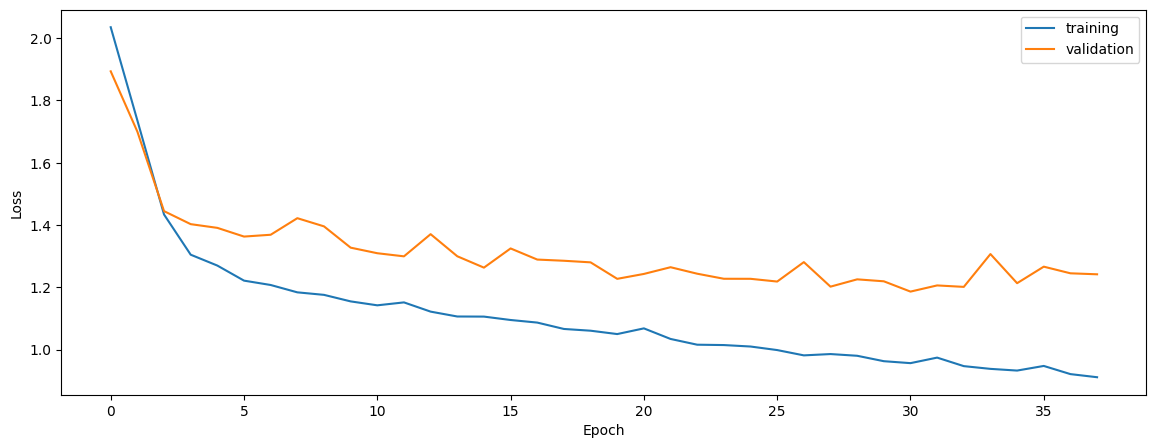

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.6291214179406098


0.5482749519248897


0.586821554323348


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.571901775392816


0.5453315290933695


0.5396716987353101


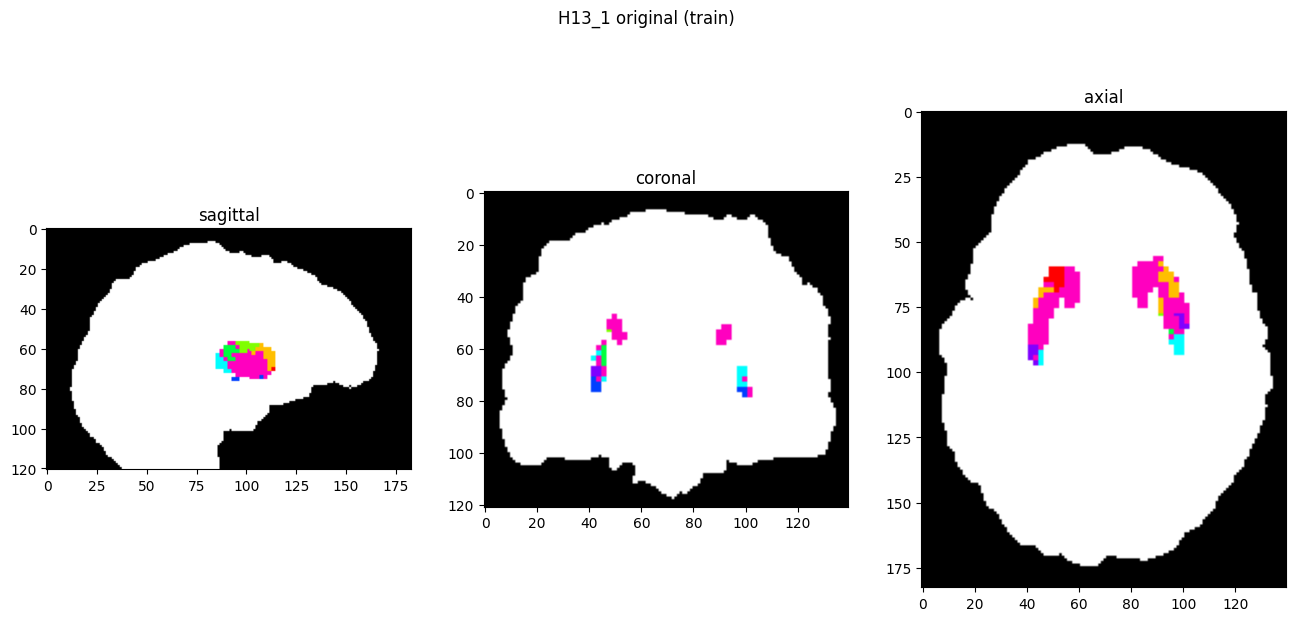

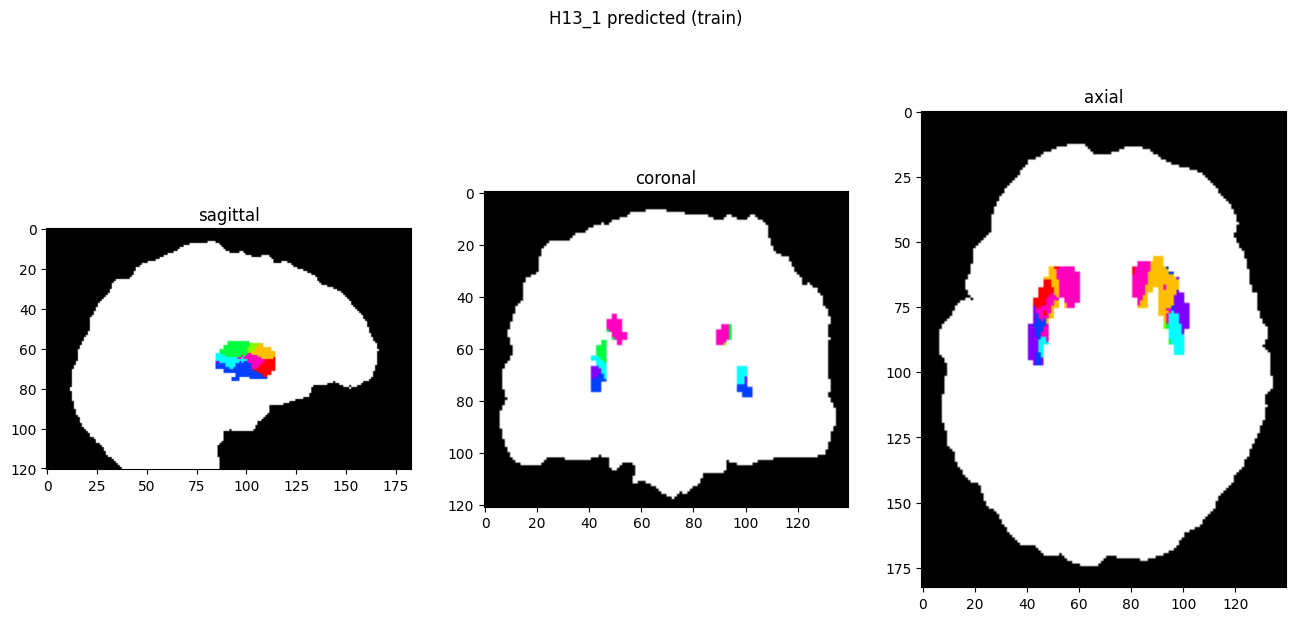

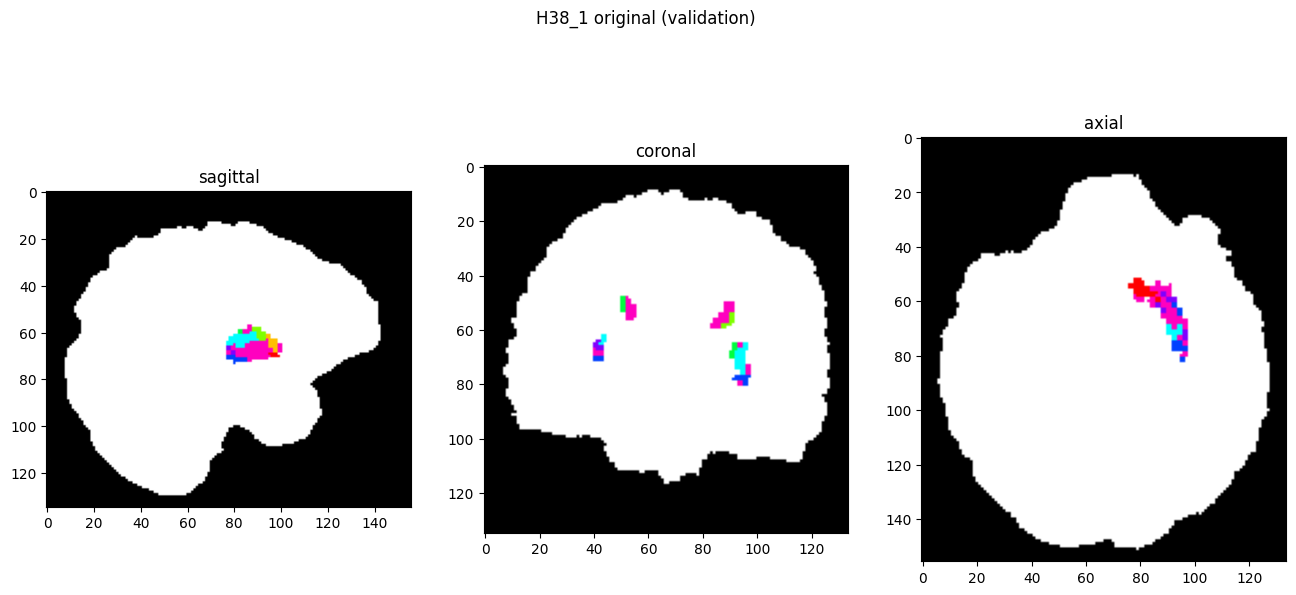

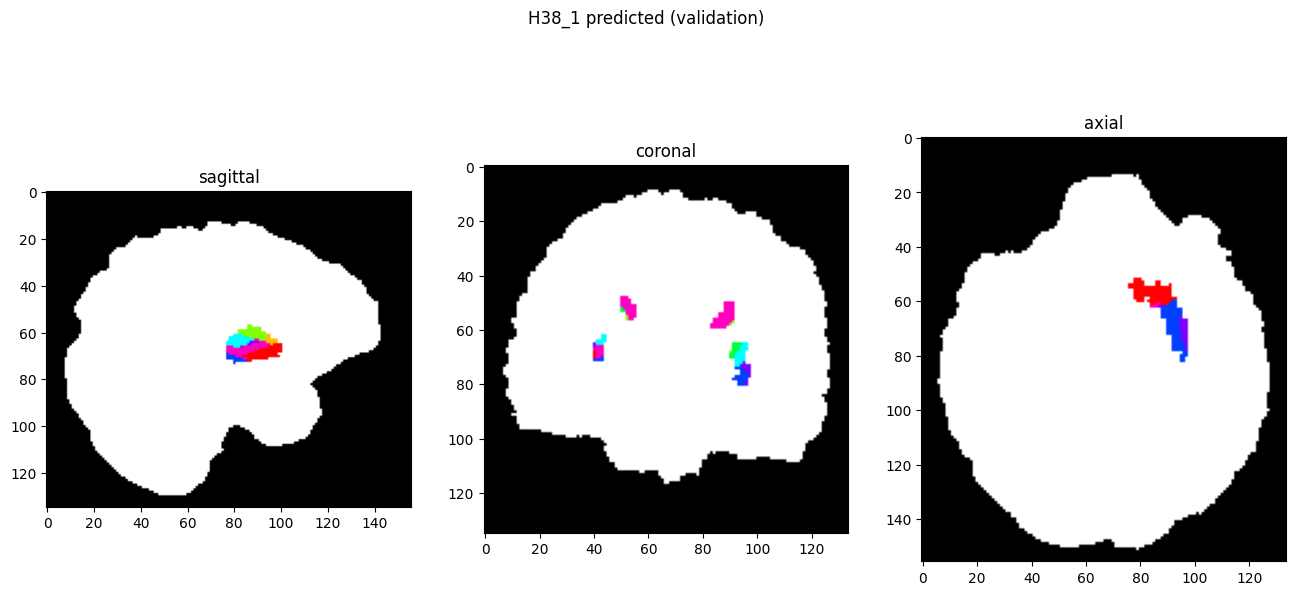

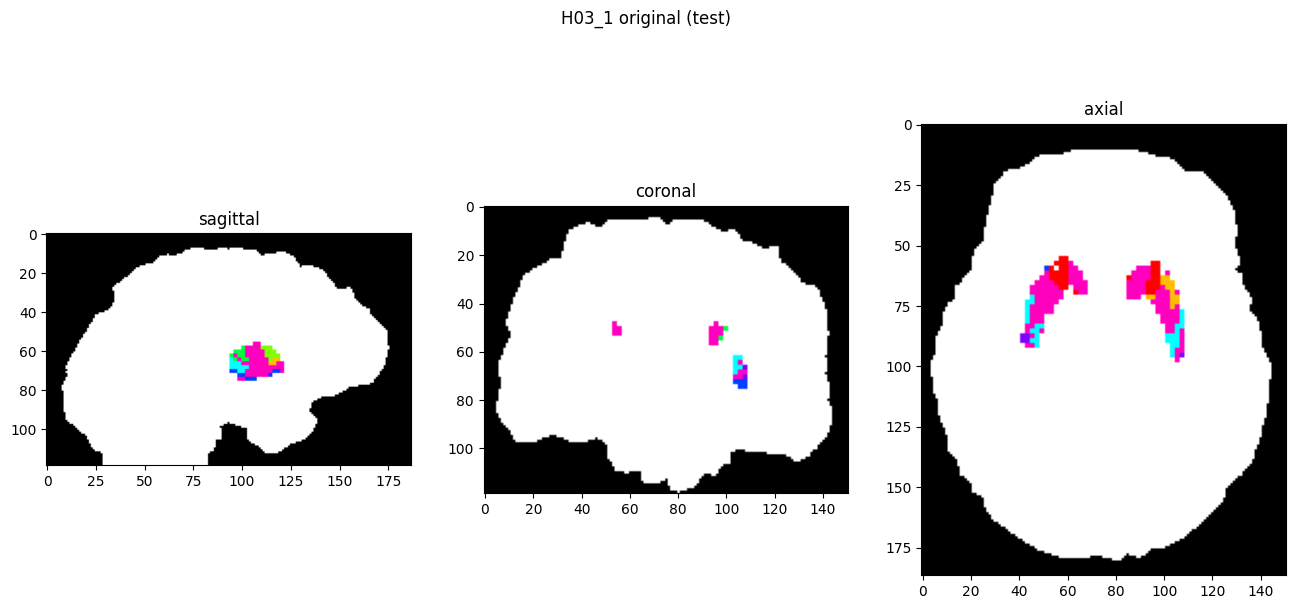

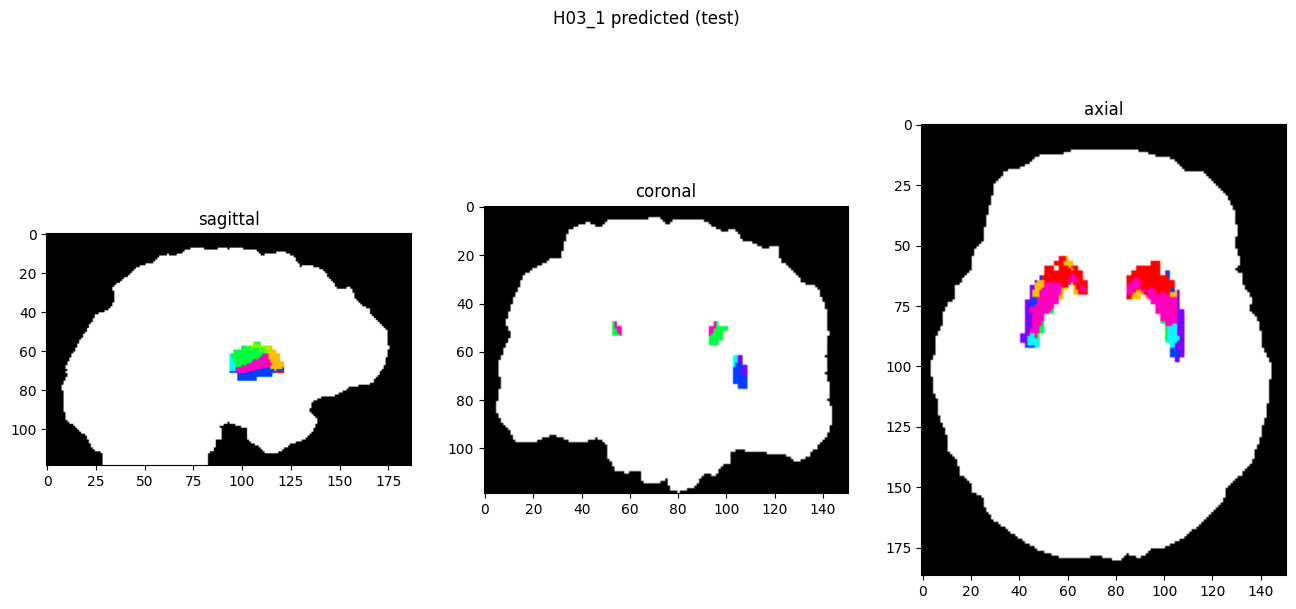

In [9]:
showResults(model, gen, threshold=0)